# Tarea 1 - Computación Cienctífica y Ciencia de los Datos
## Vectorización en Python: Generalización de autómatas de Conway
### Vicente Mieres / 21.082.122-8

## 1. Introducción

En el presente informe, se detalla la implmentacion de un generalización del juego de la vida de Conway, matriz infita con valores 0 o 1 por celda, las cuales "evolucionan" con el paso del tiempo. En particular para este trabajo, se debe extrapolar a grillas de n-dimensiones, con m posibles valores por celda. Además, este debe ser eficiente, por lo que la utilización de librerías como numpy y, sobretodo, cupy, son un requisito fundamental.

De esta forma, el objetivo de esta entrega, corresponde a la implementacion *eficiente* de un simulador, evitando el uso de ciclos tradicionales (ciclos *for* explícitos) y utilizando vectorización para trabajar de forma paralela. Además, se implmentará la version iterativa del problema, esto con el fin de realizar una comparativa a nivel de tiempo de ejecución, y asi demostrar la eficiencia de trabajar con programación paralela. Finalmente, se presentan diferentes ejemplos de la ejecución del código, para distintas combinaciones de parámetros.

## 2. Desarrollo

A continuación se detallan las consideraciones para poder implementar el autómata generalizado, tanto en su versión iterativa como en la optimizada.

### 2.1 Librerías

Para llevar a cabo el objetivo planteado, es necesario utilizar diferentes librerías, estas para poder manejar arreglos grandes, manejar la aceleracion por GPU requerida, realizar operaciones vectoriales, entre otros. Esta  se prensentan en el siguiente listado.

- **NumPy**: Encargada de la creación y manipulación de arreglos multidimensionales, operaciones vectorizadas, entre otros.
- **CuPy**: Implementacion de NumPy compatible con GPU. Permite acelerar el calculo de arreglos grandes utilizando computación paralela.
- **matplotlib.pyplot**: Biblioteca de visualización. Creación de graficas.
- **SciPy.ndimage.convolve**: Función específica de SciPy para el procesamiento de imagenes (Explicación más adelante).
- **matplotlib.use('TkAgg')**: Configura el backend de Matplotlib para creación de ventanas externas e interacción con gráficas.

In [253]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
import math

### 2.2 Versión iterativa de la solución

Con el objetivo de poder comparar tiempos de ejecución, es necesario desarrollar una implementación estándar del autámata utilizando metodos iterativos. Es decir, la solución inicial planteada no emplea técnias de vectorización, recurriendo exclusivamente al uso de ciclos *for* anidados para realizar los calculos a lo largo de la grilla y sus **n** dimensiones.

Si bien, en esta sección se explica la versión iterativa, ambas implementaciones consideran los mismos parámetros en común. Estos son:
- **r**: Radio de circunferencia, esfera, etc. Que determina la vecindad a verificar para cada celda.
- **m**: Valor maximo por celda. 
- **d**: Número de dimensiones que tendrán las grillas.
- **grid_size**: Tamaño de los arreglos en cada dimensión. 

Cabe destacar, que para la versión iterativa se utilizarán listas anidadas, mientras que para la versión eficiente se requiere utilizar arreglos de numpy.



#### 2.2.1 Obtener el valor de una celda
Función que nos permite acceder al valor de un celda, independiente de si la coordenada especificada está fuera del rango de la grilla. 

In [254]:
def get_value_toroidal(grid, coord, shape):
    """
    Obtiene el valor en una grilla d-dimensional considerando bordes periódicos (toroide).
    
    Parámetros:
    - grid: grilla como listas anidadas
    - coord: tupla de coordenadas (k0, k1, ..., kd-1)
    - shape: tupla con el tamaño de la grilla en cada dimensión

    Retorna:
    - valor correspondiente en la grilla
    """
    # Aplica el operador módulo (%) a cada coordenada para ajustar las coordenadas fuera de rango
    wrapped = tuple((coord[i] % shape[i]) for i in range(len(coord)))
    
    # Empezamos con la grilla completa, y vamos bajando por las dimensiones anidadas
    subgrid = grid
    for idx in wrapped:
        # Navega por la grilla accediendo a cada nivel de listas anidadas hasta llegar al valor final
        subgrid = subgrid[idx]
    
    # Retorna el valor que se encuentra en la celda especificada por 'coord'
    return subgrid


#### 2.2.2 Generar las coordenadas de los vecinos
Esta función es escencial para cumplir los requisitos del problema, en particular genera las coordenadas (una a una, usando *yield*) de los vecinos de una celda en específico. Esto dentro de una hiperesfera (circunferencia, esfera, etc).

In [255]:
def generate_neighbor_coordinates(coord, r):
    """
    Genera coordenadas vecinas dentro de una hiperesfera discreta de radio r.
    Excluye la celda central.

    Parámetros:
    - coord: Coordenada de la celda central (tupla de índices).
    - r: Radio de la vecindad (cuán lejos pueden estar los vecinos de la celda central).

    Retorna:
    - Vecinas: Una secuencia de coordenadas de los vecinos dentro de la hiperesfera de radio r.
    """
    # Importa los módulos necesarios para crear las combinaciones de desplazamiento y para calcular la distancia
    from itertools import product

    # `d` es la cantidad de dimensiones de la grilla
    d = len(coord)

    # Crea los rangos de desplazamiento para cada dimensión, usando el radio `r`.
    # Esto crea un hipercubo alrededor de la celda central de lado `2r + 1` en cada dimensión.
    ranges = [range(c - r, c + r + 1) for c in coord]

    # Itera sobre todas las combinaciones posibles de desplazamientos en cada dimensión
    # Usamos `product(*ranges)` para generar todas las combinaciones de índices posibles dentro del hipercubo.
    for offset in product(*ranges):
        # Calcula la distancia Euclidiana
        distance = math.sqrt(sum((offset[i] - coord[i]) ** 2 for i in range(d)))
        # Si la distancia es mayor que 0 (es decir, no es la celda central) y menor o igual a `r`,
        # entonces esta coordenada es un vecino válido y la generamos.
        if 0 < distance <= r:
            yield offset


#### 2.2.3 Inicializar una grilla vacía

In [256]:
def initialize_empty_grid(shape):
    """
    Inicializa una grilla vacía (llena de ceros) con la forma especificada en 'shape'.
    
    Parámetros:
    - shape: Tupla con las dimensiones de la grilla.
    
    Retorna:
    - Una grilla de listas anidadas con valores 0, de la forma especificada en 'shape'.
    """
    # En este caso, devolvemos 0, que es el valor por defecto para cada celda.
    if not shape:
        return 0
    # Recursión: creamos una lista con 'shape[0]' elementos, donde cada elemento es una nueva lista
    # que representa una dimensión inferior. Llamamos recursivamente a la función para crear las sublistas.
    return [initialize_empty_grid(shape[1:]) for _ in range(shape[0])]

#### 2.2.4 Suma de vecinos

In [257]:
def sum_neighbors_iterative(grid, r):
    """
    Calcula la suma de los vecinos para cada celda de una grilla d-dimensional.

    Parámetros:
    - grid: La grilla donde se calcularán las sumas de vecinos. Es una lista anidada.
    - r: El radio de vecindad (distancia máxima entre la celda y sus vecinos).

    Retorna:
    - new_grid: Grilla donde cada celda contiene la suma de los valores de sus vecinos.
    """
    # Determina la forma (shape) de la grilla. La variable 'shape' almacenará el tamaño de cada dimensión.
    shape = []

    # Calcular la forma de la grilla (tamaño de cada dimensión)
    sub = grid
    while isinstance(sub, list) and len(sub) > 0:
        shape.append(len(sub))
        sub = sub[0]

    # Inicializa la nueva grilla que contendrá las sumas de los vecinos
    new_grid = initialize_empty_grid(shape)

    # Recorre todas las celdas de la grilla
    for coord in traverse_grid(shape):
        total = 0  # Variable para almacenar la suma de los vecinos

        # Genera las coordenadas vecinas dentro del radio `r` alrededor de la celda actual
        for neighbor in generate_neighbor_coordinates(coord, r):
            # Suma el valor de cada vecino utilizando la función `get_value_toroidal` para asegurar que respete los bordes periódicos
            total += get_value_toroidal(grid, neighbor, shape)
        
        # Asigna el valor total de la suma de los vecinos en la nueva grilla
        assign_value(new_grid, coord, total)

    return new_grid


#### 2.2.6 Evolucionar grilla en función de los vecinos

In [258]:
def apply_rule(grid, sum_neighbors, m, r):
    """
    Aplica la regla de evolución al autómata celular generalizado.

    Parámetros:
    - grid: La grilla original (listas anidadas).
    - sum_neighbors: La grilla con las sumas de los vecinos.
    - m: El valor máximo permitido por celda.
    - r: El radio de vecindad.

    Retorna:
    - new_grid: La grilla actualizada después de aplicar la regla.
    """
    from math import sqrt

    # Obtener la forma (shape) de la grilla original
    shape = []
    sub = grid
    while isinstance(sub, list) and len(sub) > 0:
        shape.append(len(sub))
        sub = sub[0]

    # Calcular la cantidad total de vecinos dentro de la esfera discreta de radio `r`
    total_neighbors = 0
    from itertools import product
    d = len(shape)

    # Calcular el total de vecinos en el radio `r` para todas las direcciones
    for delta in product(*[range(-r, r + 1) for _ in range(d)]):
        if all(x == 0 for x in delta):  # Excluye la celda central
            continue
        distance = sqrt(sum(x ** 2 for x in delta))
        if distance <= r:
            total_neighbors += 1

    # Calcular el valor máximo posible (SM) basado en los vecinos
    SM = m * total_neighbors
    third = SM / 3  # Dividir el rango de posibles sumas en tres partes

    # Inicializar la nueva grilla con valores vacíos (inicialmente 0)
    new_grid = initialize_empty_grid(shape)

    # Recorremos todas las celdas de la grilla
    for coord in traverse_grid(shape):
        # Obtener el valor actual de la celda
        current_value = get_value_toroidal(grid, coord, shape)

        # Obtener la suma de los vecinos para la celda actual
        total = get_value_toroidal(sum_neighbors, coord, shape)

        # Aplicar la regla de evolución a la celda:
        if total < third:
            new_value = max(0, current_value - 1)  # Disminuir el valor (sin ir por debajo de 0)
        elif total < 2 * third:
            new_value = min(m, current_value + 1)  # Aumentar el valor (sin superar el máximo `m`)
        else:
            new_value = max(0, current_value - 1)  # Disminuir el valor (sin ir por debajo de 0)

        # Asignar el nuevo valor a la celda en la nueva grilla
        assign_value(new_grid, coord, new_value)

    return new_grid

#### 2.2.7 Simular un paso en la simulacion

In [259]:
def automaton_step(grid, m, r):
    """
    Realiza un paso completo del autómata celular:
    - Calcula la suma de los vecinos
    - Aplica la regla de evolución
    """
    sum_neighbors = sum_neighbors_iterative(grid, r)
    new_grid = apply_rule(grid, sum_neighbors, m, r)
    return new_grid

### 2.3 Versión eficiente de la solución

Una vez entendido el problema, y tomando como base la implemtación anterior. Se presenta a continuación la versión eficiente de la solución, es decir utilizando operaciones vectoriales para optimizar el manejo de arreglos y así obtener mejores tiempos de ejecución. En particular, la idea generalizada de esta implementación toma como base la *convolución*, de tal manera que se debe crear un kernel que será aplicado a todos los elementos de un grilla, y así poder obtener la suma de los vecinos requerida para posteriormente evolucionar la grilla según las reglas establecidas.

De esta forma, la solucion escogida esta conformada por diferentes parámetros y componentes. En cuanto a los parámetros, estos son los exactamente los mismos, puesto que de otra forma, se obtendrían resultados diferentes, lo cual no es optimo ni esperado. Luego, los diferentes componentes, o tambien llamados pasos, de la solución corresponden a todas las operaciones que debe hacer el simulador. Estos se encuentran listados a continuación.

- Creación de un kernel euclideano (fijo durante toda la simulación)
- Expandir la grilla
- Obtener la suma de vecinos
- Calcular intervalos
- Evolucionar la grilla


Con esto en consideración, se presenta la explicacion de cada una de los componentes implicados.

#### 2.3.1 Creación del Kernel Euclideano

En primer lugar, se considera la funcion **euclidean_kernel**, esta cumple con el objetivo de crear un máscara que recorrerá la grilla, aplicando cierto criterio, en este caso en particular, un kernel euclideano, es decir que considera a todos los vecinos de una celda en un radio r dado.

In [260]:
def euclidean_kernel(dimensions, radius):
    """
    Construye un kernel euclidiano. Forma circular en 2D, forma esférica en 3D, etc.
    
    Parámetros:
    - dimensions: Número de dimensiones.
    - radius: Radio de los vecinos.
    
    Retorna:
    - kernel: Arreglo de CuPy con 1s donde hay vecindad y 0s donde no la hay.
    """
    # Se crea la forma que tendrá el kernel
    kernel_shape = (2 * radius + 1,) * dimensions
    kernel_size = cp.prod(cp.array(kernel_shape))  # Convertir a CuPy array antes de usar prod
    
    # Se crea un arreglo con la forma del kernel
    linear_indices = cp.arange(kernel_size).reshape(kernel_shape)
    
    # Se obtienen los centros
    center_coords = cp.array([radius] * dimensions)
    
    # Transforma los índices de antes en coordenadas
    coords = cp.unravel_index(linear_indices.flatten(), kernel_shape)
    coords = cp.array(coords).reshape(dimensions, -1).T
    
    # Se usa broadcasting para obtener la distancia euclidiana
    squared_distances = cp.sum((coords - center_coords) ** 2, axis=1)
    
    # Se obtiene el kernel final con vectorización
    kernel = (squared_distances <= radius ** 2).astype(cp.int32)
    kernel = kernel.reshape(kernel_shape)
    
    # Excluir la celda central 
    kernel[tuple(center_coords)] = 0
    
    return kernel


#### 2.3.2 Expansión de la grilla

El siguiente paso a considerar, es que tal como indica el enunciado, se requiere que la grilla sea una toroide, es decir que para aquellas celdas que se encuentran en las orillas, sea posible realizar la suma de vecino de forma correcta. Para esto se utiliza la funcion *pad* de numpy con el modo *wrap*, la cual permite simular el toroide.

In [261]:
def expand_grid(grid, radius):
    """
    Expande la grilla con bordes periódicos (toroide).
    
    Parámetros:
    - grid: ndarray de CuPy.
    - radius: Radio de vecindad que determina cuánto expandir.
    
    Retorna:
    - expanded_grid: Grilla con bordes periódicos en formato CuPy.
    """
    # Asegurarse de que el grid sea un arreglo de CuPy (en caso de que se pase un ndarray de NumPy)
    if not isinstance(grid, cp.ndarray):
        grid = cp.array(grid)
    
    # Se aplica el padding con bordes periódicos (toroide)
    expanded_grid = cp.pad(grid, radius, mode='wrap')
    
    return expanded_grid


#### 2.3.3 Obtención de suma de vecinos

Tal como se mecionó anteriormente, para cada celda se debe calcular la suma de los vecinos, sin considerar la celda misma. Para esto se hace uso de la funcion *convolve* de forma similar a como se utiliza en procesamiento de imágenes. Un kernel (euclideano en este caso) es aplicado a toda la grilla, obteniendo así, una matríz nueva que contiene solamente la suma de vecinos para esa celda en particular. Además es necesario considerar, que al realizar esta convolución, el tamaño original de la grilla cambia, en este caso se hace mas grande, por tanto es necesario extrar la parte valida.

In [262]:
def get_neighbor_sum(expanded_grid, kernel):
    """
    Calcula la suma de los valores en la vecindad para cada celda.
    
    Parámetros:
    - expanded_grid: Grilla con bordes expandidos.
    - kernel: Kernel que define la vecindad.
    
    Retorna:
    - neighbor_sum: Arreglo con la suma de los valores vecinos para cada celda.
    """
    
    # Convertir expanded_grid y kernel a NumPy antes de la convolución
    expanded_grid_cpu = expanded_grid.get()  # Convertir expanded_grid a NumPy
    kernel_cpu = kernel.get()  # Convertir kernel a NumPy
    
    # Se aplica la convolución para obtener la suma de los vecinos
    neighbor_sum = convolve(expanded_grid_cpu, kernel_cpu, mode='wrap')
    
    # Se extrae la parte válida de la convolución
    radius = kernel.shape[0] // 2
    slices = tuple(slice(radius, -radius) for _ in range(expanded_grid.ndim))
    neighbor_sum = neighbor_sum[slices]
    
    # Convertir neighbor_sum de nuevo a CuPy para que esté en la GPU
    neighbor_sum = cp.array(neighbor_sum)
    
    return neighbor_sum


#### 2.3.4 Obtención de intervalos

Para este caso, simplemente es necesario utilizar la función *linspace* de numpy para generar los tres intervalos necesarios, con valor máximo SM, valor que corresponde a la suma de los vecinos multiplicado por el parámetro m.

In [263]:
def get_intervals(kernel, m):
   """
   Calcula los intervalos para aplicar las reglas de evolución.
   Parámetros:
   - kernel: Kernel que define la vecindad.
   - m: Número máximo de estados por celda.
   Retorna:
   - intervals: Arreglo con los límites de los 3 intervalos.
   """
   # Sumar los valores del kernel con CuPy
   num_neighbors = cp.sum(kernel)  
   # Calcular SM
   SM = m * num_neighbors
   # Crear los intervalos con linspace
   intervals = cp.linspace(0, SM, 4)  # 3 intervalos (4 valores para los límites)
   return intervals


#### 2.3.5 Evolución de la grilla

La siguiente función, es la encargada de aplicar las reglas establecidas anteriormente. Primero, creando máscaras booleanas, que cumplan con los intervalos. Y luego utiliza la indexación de las grillas para sumar o restar 1 según corresponda.

In [264]:
def evolve_grid(grid, neighbor_sum, intervals, m):
   """
   Aplica las reglas de evolución al autómata celular.
   
   Parámetros:
   - grid: Configuración actual del autómata.
   - neighbor_sum: Suma de los valores en la vecindad para cada celda.
   - intervals: Límites de los intervalos para aplicar las reglas.
   - m: Número máximo de estados por celda.
   
   Retorna:
   - new_grid: Grilla evolucionada según las reglas.
   """
   # Se hace una copia para evitar modificar la original
   new_grid = cp.copy(grid) 
   
   # Asegurarse de que neighbor_sum es de CuPy
   if not isinstance(neighbor_sum, cp.ndarray):
       neighbor_sum = cp.array(neighbor_sum)
   
   # Aplicar reglas con las máscaras
   mask1 = (neighbor_sum >= intervals[0]) & (neighbor_sum < intervals[1])
   mask2 = (neighbor_sum >= intervals[1]) & (neighbor_sum < intervals[2])
   mask3 = (neighbor_sum >= intervals[2])
   
   # Asegurarse de que new_grid es de CuPy antes de hacer las operaciones
   new_grid = cp.array(new_grid)  # Si por alguna razón new_grid es NumPy, lo convertimos a CuPy.
   
   # Aplicar cambios usando las máscaras y las funciones de CuPy
   new_grid[mask1] = cp.maximum(new_grid[mask1] - 1, 0)  
   new_grid[mask2] = cp.minimum(new_grid[mask2] + 1, m)  
   new_grid[mask3] = cp.maximum(new_grid[mask3] - 1, 0)
   
   return new_grid


## 3. Funciones Auxiliares

A continuación se presentan funciones auxiliares, estas  se utilizan para creación de grillas con patrones específicos, o visualización de la mismas para N dimensiones.

In [ ]:
def create_grid(d, grid_size, m, pattern='random'):
    """
    Crea una grilla n-dimensional con un patrón especificado.
   
    Parámetros:
    - d: número de dimensiones
    - grid_size: tamaño de cada dimensión. (Longitud del arreglo)
    - m: valor máximo para cada celda
    - pattern: tipo de patrón inicial (
        'random', 'central', 'checkerboard', 'cross', 'line',
        'border', 'diagonal', 'ring', 'gradient', 'random_sparse',
        'stripes', 'horizontal_stripes', 'vertical_stripes'
    )

    Retorna:
    - grid: grilla n-dimensional con el patrón elegido
    """
    # Normalizar grid_size a tupla
    if isinstance(grid_size, int):
        grid_size = tuple([grid_size] * d)
    else:
        grid_size = tuple(grid_size)

    # RANDOM
    if pattern == 'random':
        return cp.random.randint(0, m+1, grid_size)

    # CENTRAL
    elif pattern == 'central':
        grid = cp.zeros(grid_size, dtype=int)
        center = tuple(s // 2 for s in grid_size)
        indices = tuple(slice(c-1, c+2) for c in center)
        grid[indices] = m
        return grid

    # CHECKERBOARD
    elif pattern == 'checkerboard':
        idx = cp.indices(grid_size)
        sum_idx = cp.sum(idx, axis=0)
        return (sum_idx % 2) * m

    # CROSS
    elif pattern == 'cross':
        grid = cp.zeros(grid_size, dtype=int)
        center = tuple(s // 2 for s in grid_size)
        for dim in range(d):
            indices = [slice(0, s) if i != dim else center[i] for i, s in enumerate(grid_size)]
            grid[tuple(indices)] = m
        return grid

    # LINE
    elif pattern == 'line':
        grid = cp.zeros(grid_size, dtype=int)
        if d >= 2:
            indices = [slice(grid_size[0]//2, grid_size[0]//2+1), slice(0, grid_size[1])]
            for dim in range(2, d):
                indices.append(grid_size[dim] // 2)
            grid[tuple(indices)] = m
        else:
            grid[:] = m
        return grid

    # BORDER
    elif pattern == 'border':
        grid = cp.zeros(grid_size, dtype=int)
        # Todas las caras externas
        slices = []
        for dim in range(d):
            face_low = [slice(None)]*d
            face_high = [slice(None)]*d
            face_low[dim] = 0
            face_high[dim] = grid_size[dim]-1
            grid[tuple(face_low)] = m
            grid[tuple(face_high)] = m
        return grid

    # DIAGONAL (main diagonal en n dims)
    elif pattern == 'diagonal':
        grid = cp.zeros(grid_size, dtype=int)
        length = min(grid_size)
        for i in range(length):
            grid[tuple([i]*d)] = m
        return grid

    # RING (esfera discreta)
    elif pattern == 'ring':
        idx = cp.indices(grid_size)
        center = cp.array([s/2 for s in grid_size]).reshape((d,) + (1,)*d)
        dist = cp.sqrt(cp.sum((idx - center)**2, axis=0))
        radius = min(grid_size)/4
        return (dist <= radius) * m

    # GRADIENT (a lo largo del primer eje)
    elif pattern == 'gradient':
        grad = cp.linspace(0, m, grid_size[0], dtype=float)
        shape_grad = [grid_size[0]] + [1]*(d-1)
        grad = grad.reshape(shape_grad)
        grid = cp.broadcast_to(grad, grid_size)
        return grid

    # RANDOM_SPARSE (~10% de puntos al azar)
    elif pattern == 'random_sparse':
        grid = cp.zeros(grid_size, dtype=int)
        total = grid.size
        count = max(1, total // 10)
        inds = cp.random.choice(total, count, replace=False)
        coords = cp.unravel_index(inds, grid_size)
        grid[coords] = m
        return grid

    # STRIPES (bandas alternas en primer eje)
    elif pattern == 'stripes':
        idx = cp.indices(grid_size)
        return (idx[0] % 2) * m

    # HORIZONTAL_STRIPES (filas alternas, 2D+)
    elif pattern == 'horizontal_stripes' and d >= 2:
        idx = cp.indices(grid_size)
        return (idx[0] % 2) * m

    # VERTICAL_STRIPES (columnas alternas, 2D+)
    elif pattern == 'vertical_stripes' and d >= 2:
        idx = cp.indices(grid_size)
        return (idx[1] % 2) * m

    # PATRON DESCONOCIDO: zeros
    else:
        return cp.zeros(grid_size, dtype=int)


In [266]:
def visualize_automaton(grid, m, r, iterations=5, pause=1, cmap='viridis', show=True, mode='optimized'):
    """
    Simula y visualiza la evolución del autómata celular en ventanas secuenciales para grillas en 2d.
    Elige entre el método iterativo o optimizado según el parámetro `mode`.
   
    Parámetros:
    - grid: grilla inicial (2D o lista anidada)
    - m: valor máximo para cada celda
    - r: radio de vecindad
    - iterations: número de iteraciones
    - pause: tiempo entre iteraciones (segundos)
    - cmap: mapa de colores
    - show: si True, muestra las imágenes paso a paso; si False, solo devuelve el historial de grillas.
    - mode: 'iterative' o 'optimized' para elegir el tipo de simulación.
    """
    # Desactiva el modo interactivo de matplotlib
    plt.ioff()

    if mode == 'optimized':
        current_grid = cp.array(grid)  # Asegurarnos de que grid es de CuPy
    else: 
        current_grid = grid.copy()
    

    # Historial de grillas generadas
    history = [current_grid.copy()]

    # Simulación basada en el modo seleccionado
    if mode == 'iterative':
        # Ejecuta el modo iterativo (para listas anidadas)
        for step in range(iterations):
            current_grid = automaton_step(current_grid, m, r)  # Función iterativa
            history.append(current_grid.copy())

        history = np.array(history)  # Usar CuPy para la historia de grillas

    elif mode == 'optimized':
        # Ejecuta el modo optimizado (con CuPy)
        kernel = euclidean_kernel(current_grid.ndim, r)
        for step in range(iterations):
            expanded_grid = expand_grid(current_grid, r)
            neighbor_sum = get_neighbor_sum(expanded_grid, kernel)
            intervals = get_intervals(kernel, m)
            current_grid = evolve_grid(current_grid, neighbor_sum, intervals, m)
            history.append(current_grid.copy())
    else:
        raise ValueError("Invalid mode. Choose 'iterative' or 'optimized'.")

    # Si `show` es True, mostramos las imágenes
    if show:
        # Mostrar cada grilla secuencialmente
        for step, grid in enumerate(history):
            fig = plt.figure(figsize=(8, 6), num=f"Cellular Automaton - Step {step}")
                    
            if mode == 'optimized':
                grid_numpy = grid.get() 
            else:
                grid_numpy = grid

            plt.imshow(grid_numpy, cmap=cmap, interpolation='nearest')
            plt.colorbar(label='Cell State')
            plt.title(f"Step {step}" + (" (Initial)" if step == 0 else ""))
            plt.grid(True, which='both', color='white', linestyle='-', alpha=0.3)

            # Muestra la imagen durante 'pause' segundos
            if step < len(history) - 1:
                plt.tight_layout()
                plt.show(block=False)
                plt.pause(pause)
                plt.close()
            else:
                plt.tight_layout()
                plt.show()

    # Si `show` es False, solo retornamos el historial de grillas generadas
    return history


In [267]:
def visualize_automaton_nd(initial_grid, m, r, iterations=5, pause=1, cmap='viridis', visualization_axes=(0, 1), shape=None, fixed_values=None, show=True, mode='optimized'):
    """
    Simula y visualiza la evolución del autómata celular en dimensiones superiores a 2.
    Muestra cortes 2D manteniendo fijas las otras dimensiones.
    
    Parámetros:
    - initial_grid: grilla inicial n-dimensional (lista anidada o arreglo CuPy)
    - m: valor máximo del estado
    - r: radio de vecindad
    - iterations: número de iteraciones a simular
    - pause: tiempo entre iteraciones (segundos)
    - cmap: mapa de colores
    - visualization_axes: tupla con los dos ejes a visualizar (por defecto (0,1))
    - fixed_values: diccionario con valores fijos para otras dimensiones {dim: valor}
                     Si es None, se usará el punto medio de cada dimensión no visualizada
    - show: si True, muestra las imágenes paso a paso; si False, solo devuelve el historial de grillas.
    - mode: 'iterative' o 'optimized' para elegir la versión del código a ejecutar.
    """
    # Desactiva el modo interactivo de matplotlib
    plt.ioff()

    if mode == 'optimized': 
        current_grid = cp.array(initial_grid) 
    else: 
        current_grid = initial_grid.copy()

    # Historial de las grillas generadas
    history = [current_grid.copy()]

    # Simulación basada en el modo seleccionado
    if mode == 'iterative':
        # Si es iterativa, usaremos el código iterativo con listas anidadas
        for step in range(iterations):
            current_grid = automaton_step(current_grid, m, r)  # Función iterativa
            history.append(current_grid.copy())

        history = cp.array(history)  # Usamos CuPy para la historia de grillas

    elif mode == 'optimized':
        # Si es optimizada, usamos el código optimizado
        kernel = euclidean_kernel(current_grid.ndim, r)
        for step in range(iterations):
            expanded_grid = expand_grid(current_grid, r)
            neighbor_sum = get_neighbor_sum(expanded_grid, kernel)
            intervals = get_intervals(kernel, m)
            current_grid = evolve_grid(current_grid, neighbor_sum, intervals, m)
            history.append(current_grid.copy())
    else:
        raise ValueError("Invalid mode. Choose 'iterative' or 'optimized'.")

    # Si `show` es True, mostramos las imágenes
    if show:
        # Determinamos las dimensiones fijas para las dimensiones no visualizadas
        if fixed_values is None:
            fixed_values = {}

        # Obtenemos las dimensiones de la grilla
        dimensions = shape
        ndim = len(dimensions)

        # Verificamos que los ejes de visualización sean válidos
        axis_x, axis_y = visualization_axes
        if axis_x >= ndim or axis_y >= ndim or axis_x < 0 or axis_y < 0 or axis_x == axis_y:
            raise ValueError(f"Visualization axes must be different and less than {ndim}")

        # Asignamos valores por defecto para las dimensiones no visualizadas
        for dim in range(ndim):
            if dim != axis_x and dim != axis_y and dim not in fixed_values:
                fixed_values[dim] = dimensions[dim] // 2  # Punto medio como valor por defecto

        # Mostrar cada grilla secuencialmente
        for step, grid in enumerate(history):
            fig = plt.figure(figsize=(8, 6), num=f"Cellular Automaton {ndim}D - Step {step}")
            
            # Convertimos el arreglo de CuPy a NumPy para la visualización
            
            grid_numpy = grid.get()  

            # Extraemos el corte 2D para la visualización
            indices = [slice(None) if i == axis_x or i == axis_y else fixed_values[i] for i in range(ndim)]
            slice_2d = grid_numpy[tuple(indices)]
            
            # Mostramos el corte 2D
            plt.imshow(slice_2d, cmap=cmap, interpolation='nearest')
            plt.colorbar(label='Cell State')
            
            # Creamos el título con la información del corte
            slice_info = ", ".join([f"dim{i}={fixed_values[i]}" for i in range(ndim)
                                   if i != axis_x and i != axis_y])
            plt.title(f"Step {step} ({slice_info})" + (" (Initial)" if step == 0 else ""))
            
            plt.xlabel(f"Dimension {axis_x}")
            plt.ylabel(f"Dimension {axis_y}")
            plt.grid(True, which='both', color='white', linestyle='-', alpha=0.3)
            
            # Muestra la imagen durante 'pause' segundos
            if step < len(history) - 1:
                plt.tight_layout()
                plt.show(block=False)
                plt.pause(pause)
                plt.close()
            else:
                # Para la última ventana, muestra sin bloquear
                plt.tight_layout()
                plt.show()

    # Si `show` es False, solo retornamos el historial de grillas generadas
    return history


In [268]:
def traverse_grid(shape):
    """
    Genera todas las coordenadas posibles dentro de una grilla de acuerdo con su forma (shape).

    Parámetros:
    - shape: Tupla que representa las dimensiones de la grilla.
             Cada elemento de la tupla indica el tamaño de la grilla en esa dimensión.

    Retorna:
    - Un iterador que produce todas las coordenadas posibles de la grilla.
    """
    # Importa 'product' de itertools para generar el producto cartesiano de los rangos
    from itertools import product

    # Genera una lista de rangos para cada dimensión en 'shape'.
    # Para cada dimensión, el rango será 'range(s)', donde 's' es el tamaño de esa dimensión.
    return product(*[range(s) for s in shape])

In [269]:
def assign_value(grid, coord, value):
    """
    Asigna un valor a una celda específica en la grilla según las coordenadas.

    Parámetros:
    - grid: La grilla donde se asignará el valor. Es una lista anidada.
    - coord: Tupla de coordenadas (k0, k1, ..., kd-1) que indica la posición en la grilla.
    - value: El valor que se asignará a la celda especificada por 'coord'.

    """
    sub = grid  # Inicializa 'sub' como la grilla completa.
    
    # Recorre la lista de coordenadas, bajando nivel por nivel. Excluye la ultima.
    for idx in coord[:-1]:  
        sub = sub[idx]  # Navega hacia la subgrilla correspondiente.

    # Asigna el valor en la celda final (la última coordenada de 'coord')
    sub[coord[-1]] = value

In [ ]:
def simulation(grid, m , r, iterations, mode = 'optimized'):
    """
    Ejecuta una simulación del autómata segun los parámetros dados.
    """
    if mode == 'iterative':
        # Ejecuta el modo iterativo 
        current_grid = grid.tolist()

        for step in range(iterations):
            current_grid = automaton_step(current_grid, m, r) 
 
    elif mode == 'optimized':
        # Ejecuta el modo optimizado (con CuPy)
        kernel = euclidean_kernel(grid.ndim, r)
        for step in range(iterations):
            expanded_grid = expand_grid(grid, r)
            neighbor_sum = get_neighbor_sum(expanded_grid, kernel)
            intervals = get_intervals(kernel, m)
            grid = evolve_grid(grid, neighbor_sum, intervals, m)

In [320]:
def plot_images_wrap(arrays, cmap='viridis', images_per_row=4,
                     visualization_axes=(0, 1), fixed_indices=None):
    """
    Dibuja un listado de arreglos de CuPy (o convertibles) apilados
    horizontalmente y envueltos en múltiples filas, soportando arrays
    de más de 2 dimensiones.

    Parámetros:
    - arrays: listado de arreglos (NumPy, CuPy, lista, etc.) a mostrar
    - cmap: mapa de colores para las imágenes (por defecto 'viridis')
    - images_per_row: número de imágenes por fila (por defecto 4)
    - visualization_axes: tupla con los dos ejes que se visualizarán
    - fixed_indices: dict opcional {axis: índice} para ejes >2D;
      si no se proporciona, usa el punto medio de cada eje extra.
    """
    # Convertir a cupy.ndarray
    arrays = [cp.asarray(a) for a in arrays]
    n = len(arrays)
    nrows = math.ceil(n / images_per_row)

    # Crear figura y ejes
    fig, axes = plt.subplots(nrows, images_per_row,
                             figsize=(6 * images_per_row, 6 * nrows))
    # Asegurar estructura 2D
    if nrows == 1:
        axes = [axes]
    elif images_per_row == 1:
        axes = [[ax] for ax in axes]

    for i, ax_row in enumerate(axes):
        for j, ax in enumerate(ax_row):
            idx = i * images_per_row + j
            if idx < n:
                arr = arrays[idx]
                # Preparar slicing para extraer 2D
                slicers = []
                for ax_dim in range(arr.ndim):
                    if ax_dim in visualization_axes:
                        slicers.append(slice(None))
                    else:
                        if fixed_indices and ax_dim in fixed_indices:
                            slicers.append(fixed_indices[ax_dim])
                        else:
                            slicers.append(arr.shape[ax_dim] // 2)
                slice_tuple = tuple(slicers)
                arr2d = arr[slice_tuple].get()

                ax.imshow(arr2d, cmap=cmap, interpolation='nearest')
                ax.set_title(f"Step {idx}")
                ax.axis('off')
            else:
                ax.axis('off')

    plt.tight_layout(pad=2.0)
    plt.show()


## 4. Ejemplos

### 4.1 Ejemplo 1 - Cruz simple en 2D

In [407]:
r = 2
m = 3
d = 2
griz_size = 15
grid = create_grid(d, griz_size, m, pattern='cross')

In [408]:
%%time
ex1_1 = visualize_automaton(grid, m, r, iterations=10, show=False, mode='optimized')

CPU times: total: 62.5 ms
Wall time: 63.3 ms


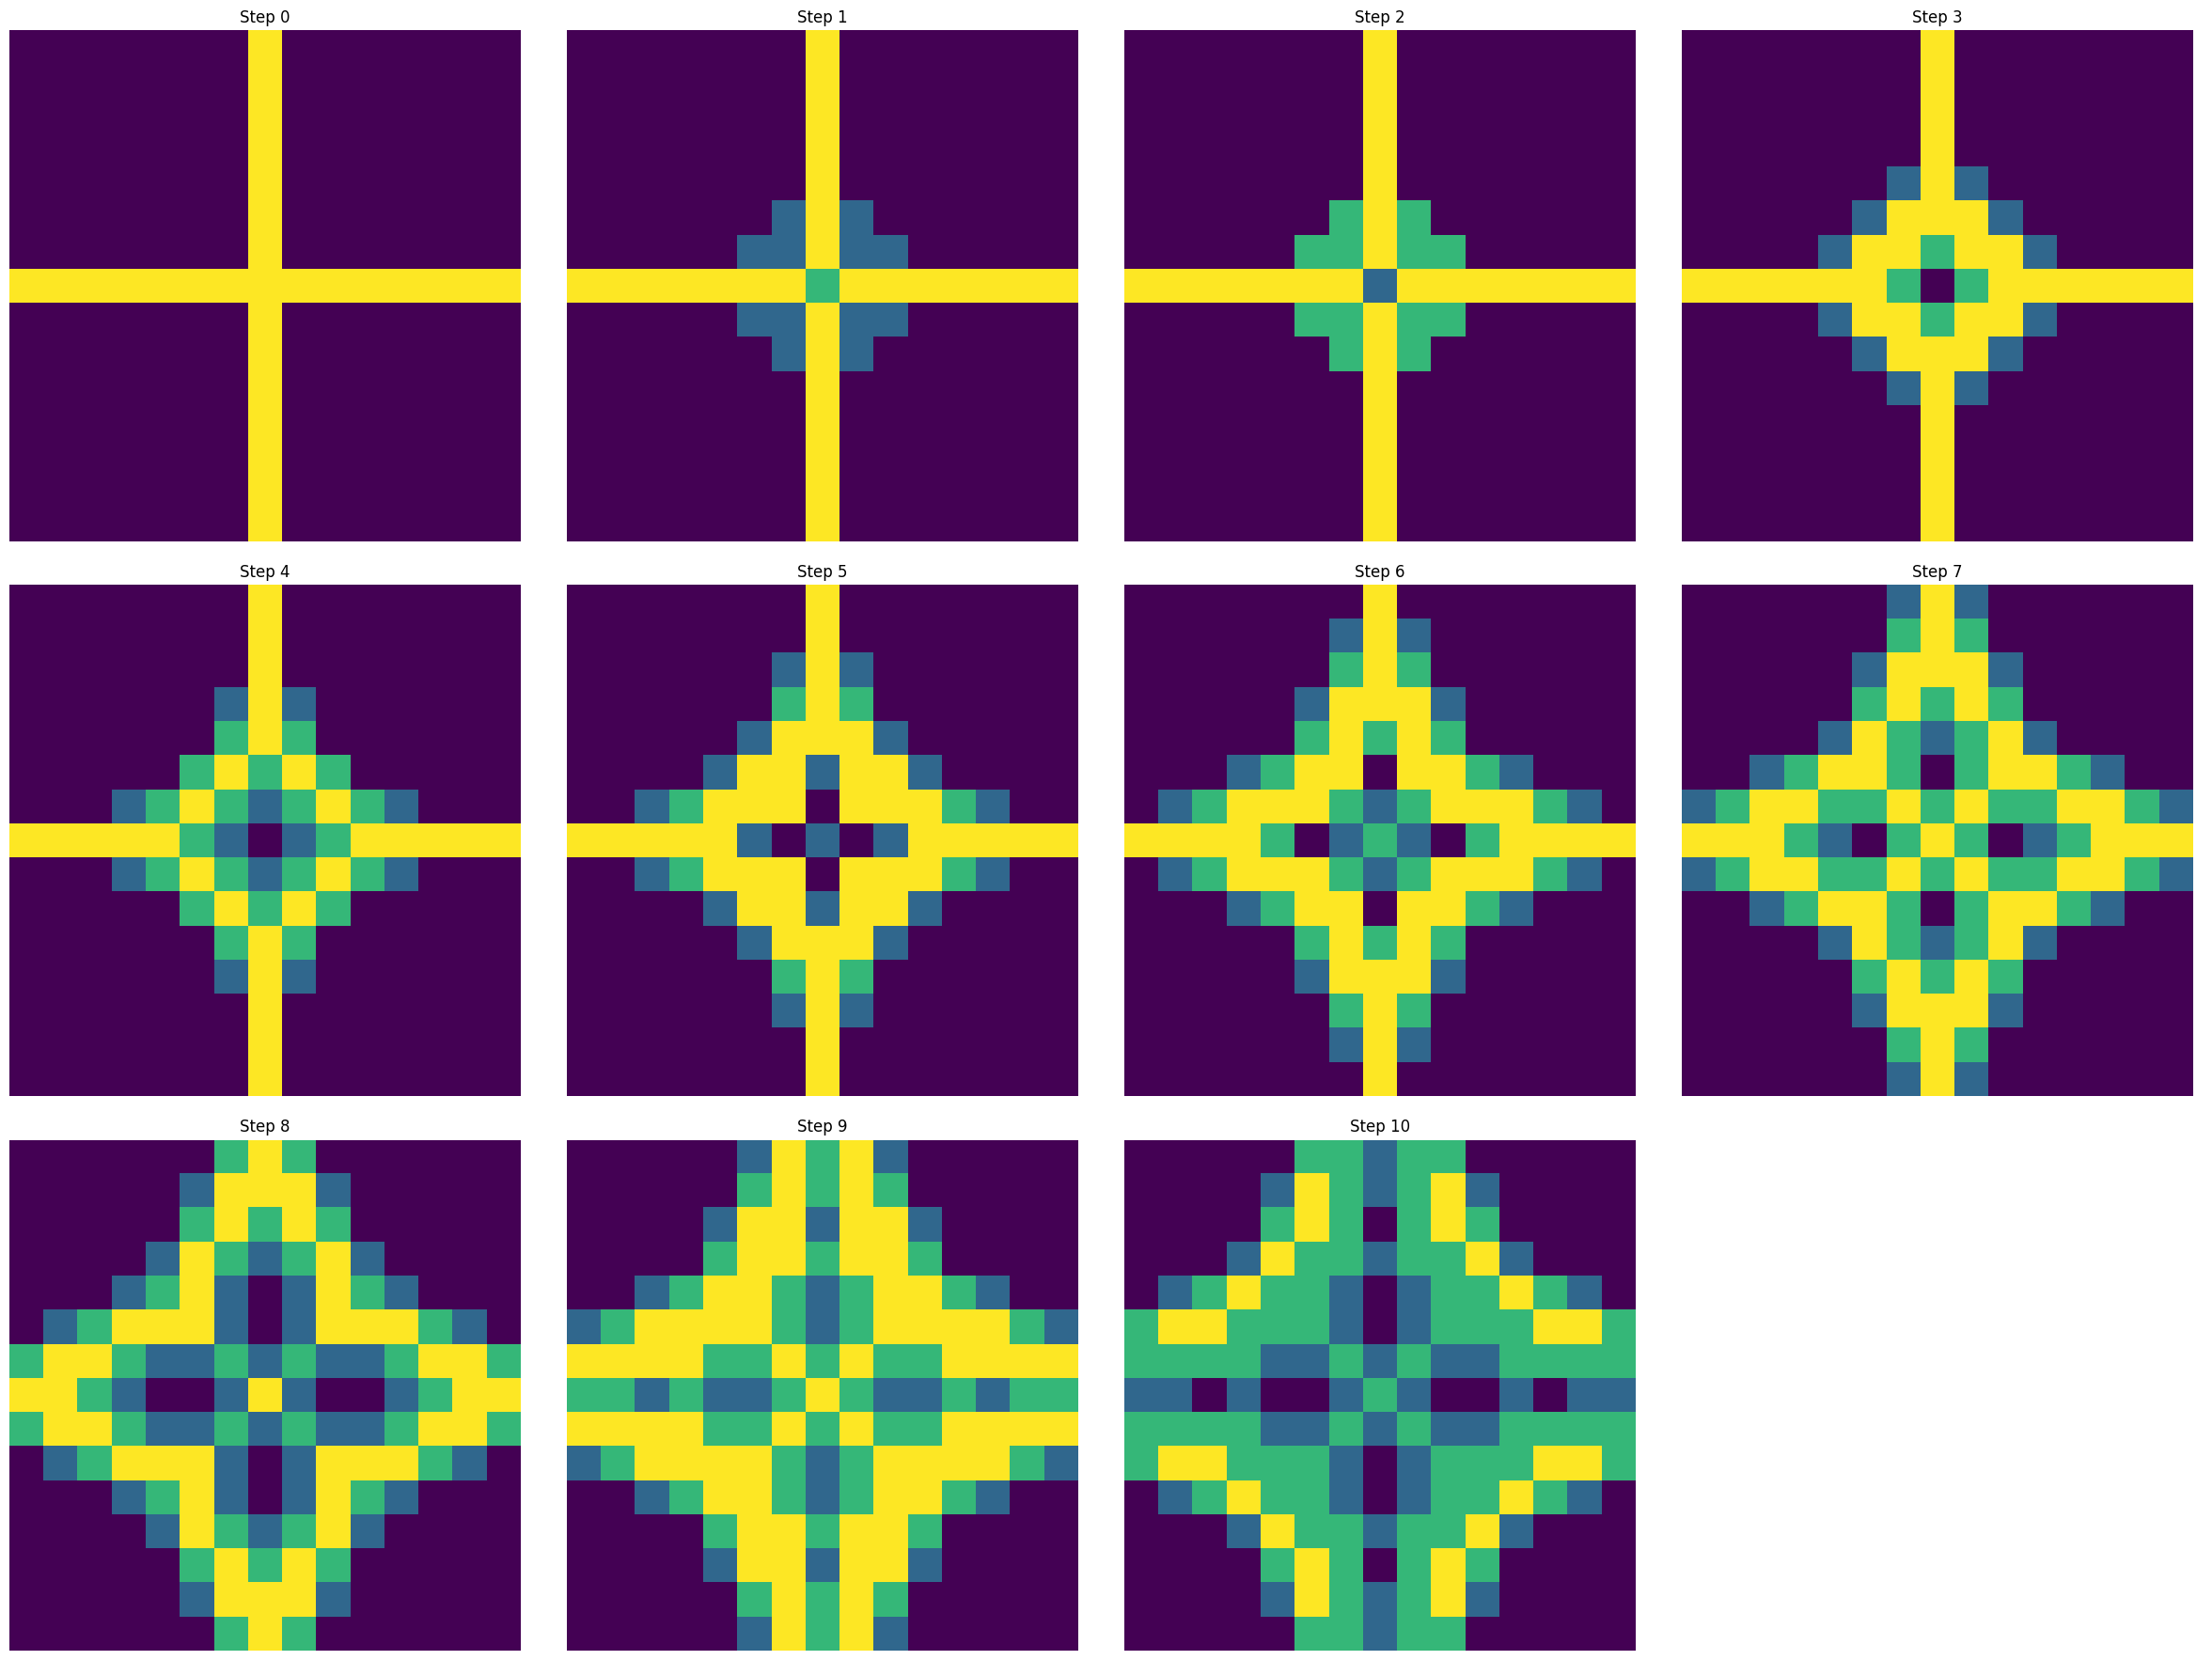

In [409]:
plot_images_wrap(ex1_1)

In [410]:
%%time
ex1_2 = visualize_automaton(grid.tolist(), m, r, iterations=10, show=False, mode='iterative')

CPU times: total: 125 ms
Wall time: 128 ms


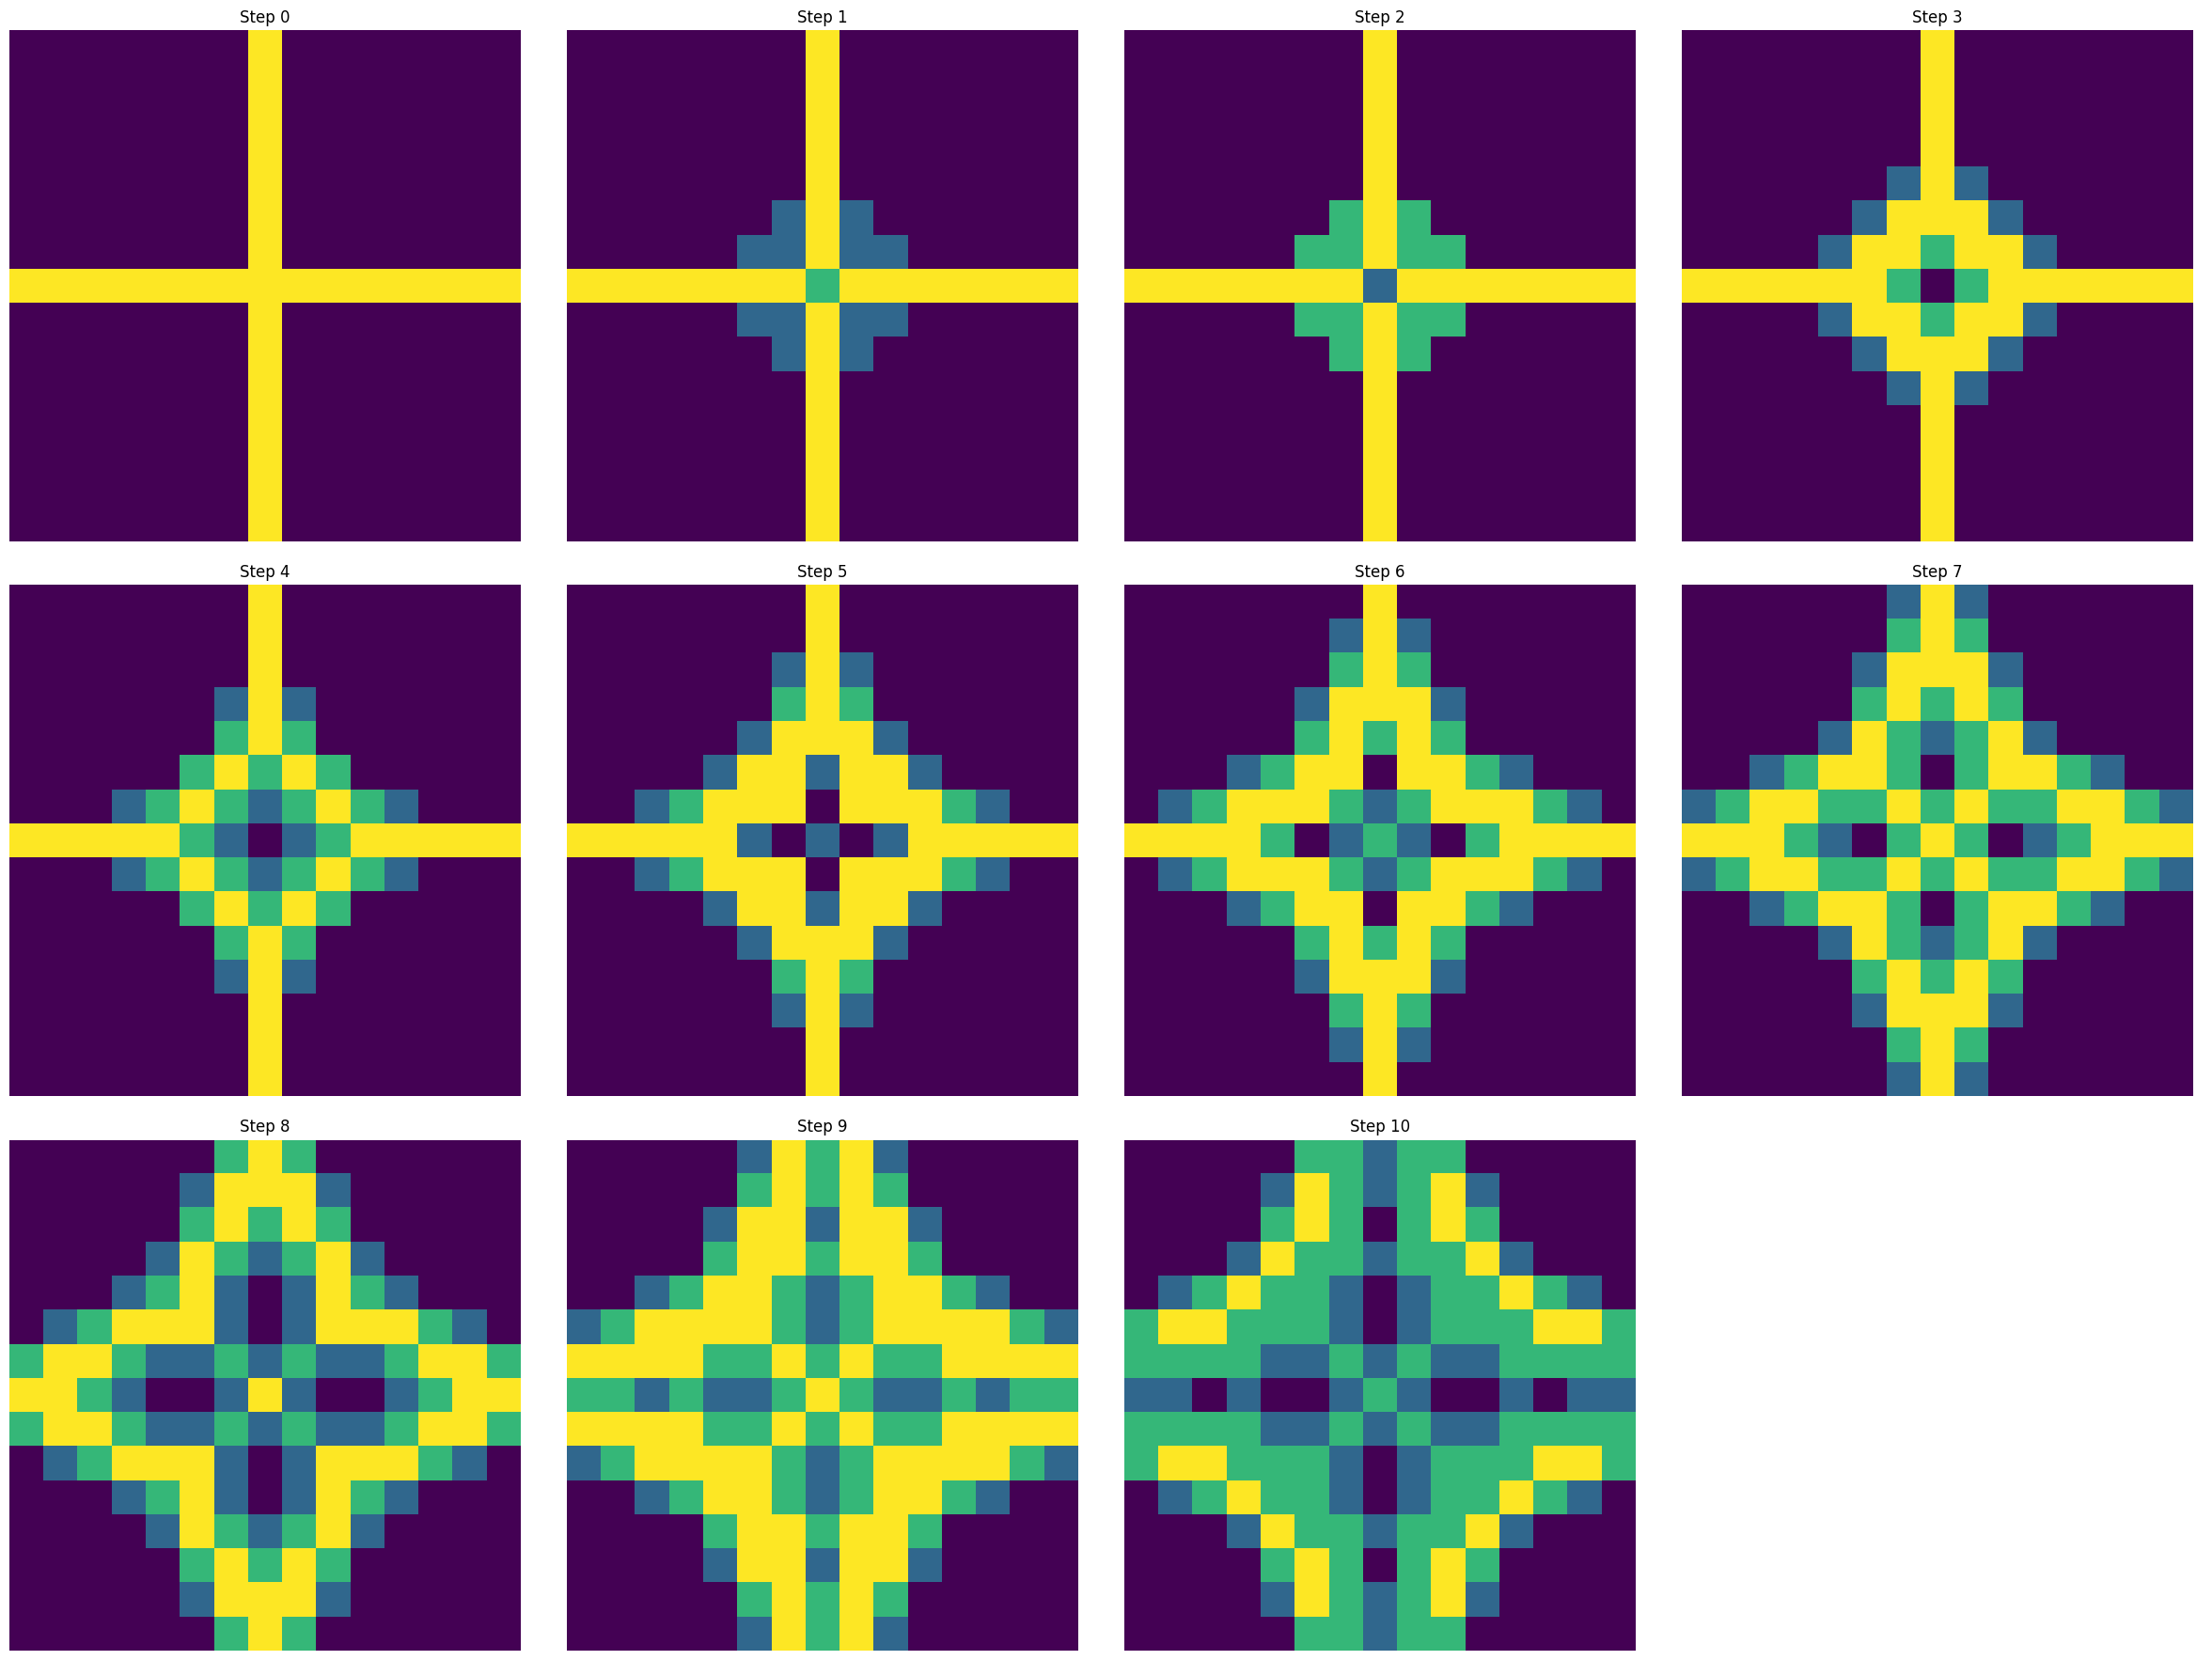

In [411]:
plot_images_wrap(ex1_2)

### 4.2 Ejemplo 2 - Generacion de bordes en 3D

In [315]:
r = 2
m = 3
d = 3
griz_size = 21
grid = create_grid(d, griz_size, m, pattern='border')

In [316]:
%%time
ex2_1 = visualize_automaton_nd(grid, m ,r , iterations=10, mode='optimized', shape=grid.shape, show=False, visualization_axes=(1,2))

CPU times: total: 62.5 ms
Wall time: 81 ms


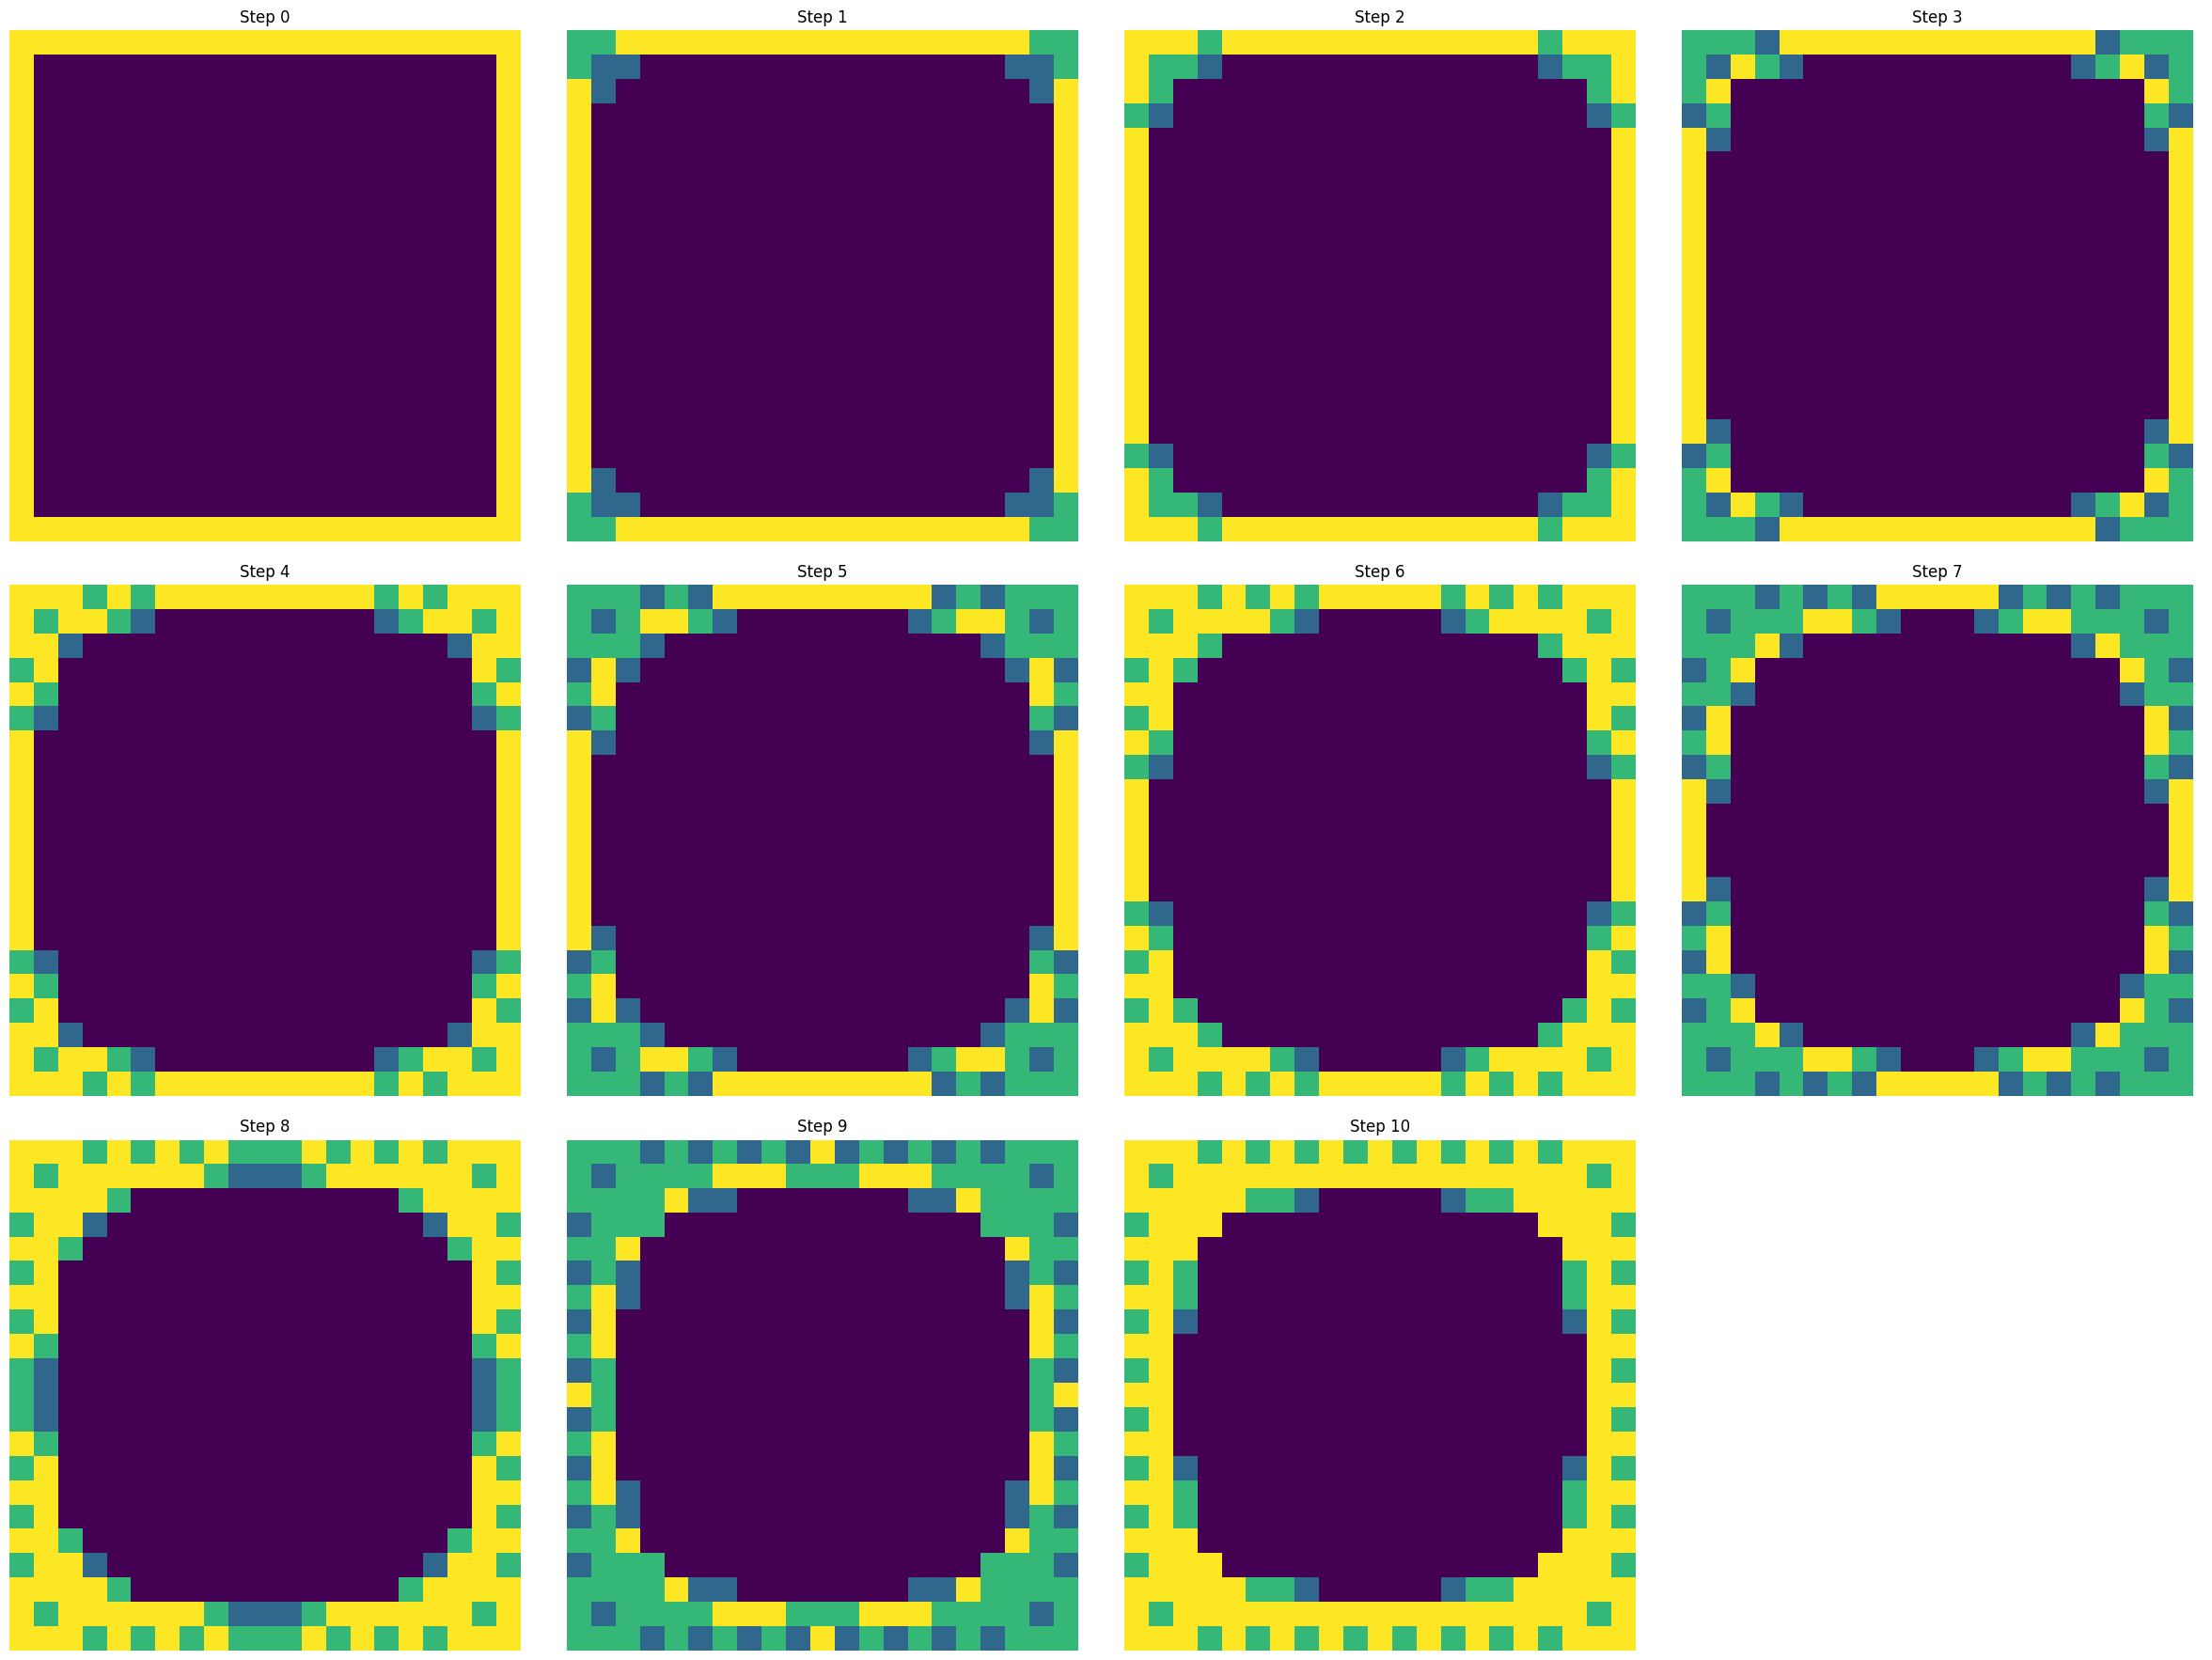

In [321]:
plot_images_wrap(ex2_1)

In [324]:
%%time
ex2_2 = visualize_automaton_nd(grid.tolist(), m ,r , iterations=10, mode='iterative', shape=grid.shape, show=False)

CPU times: total: 21.8 s
Wall time: 24.4 s


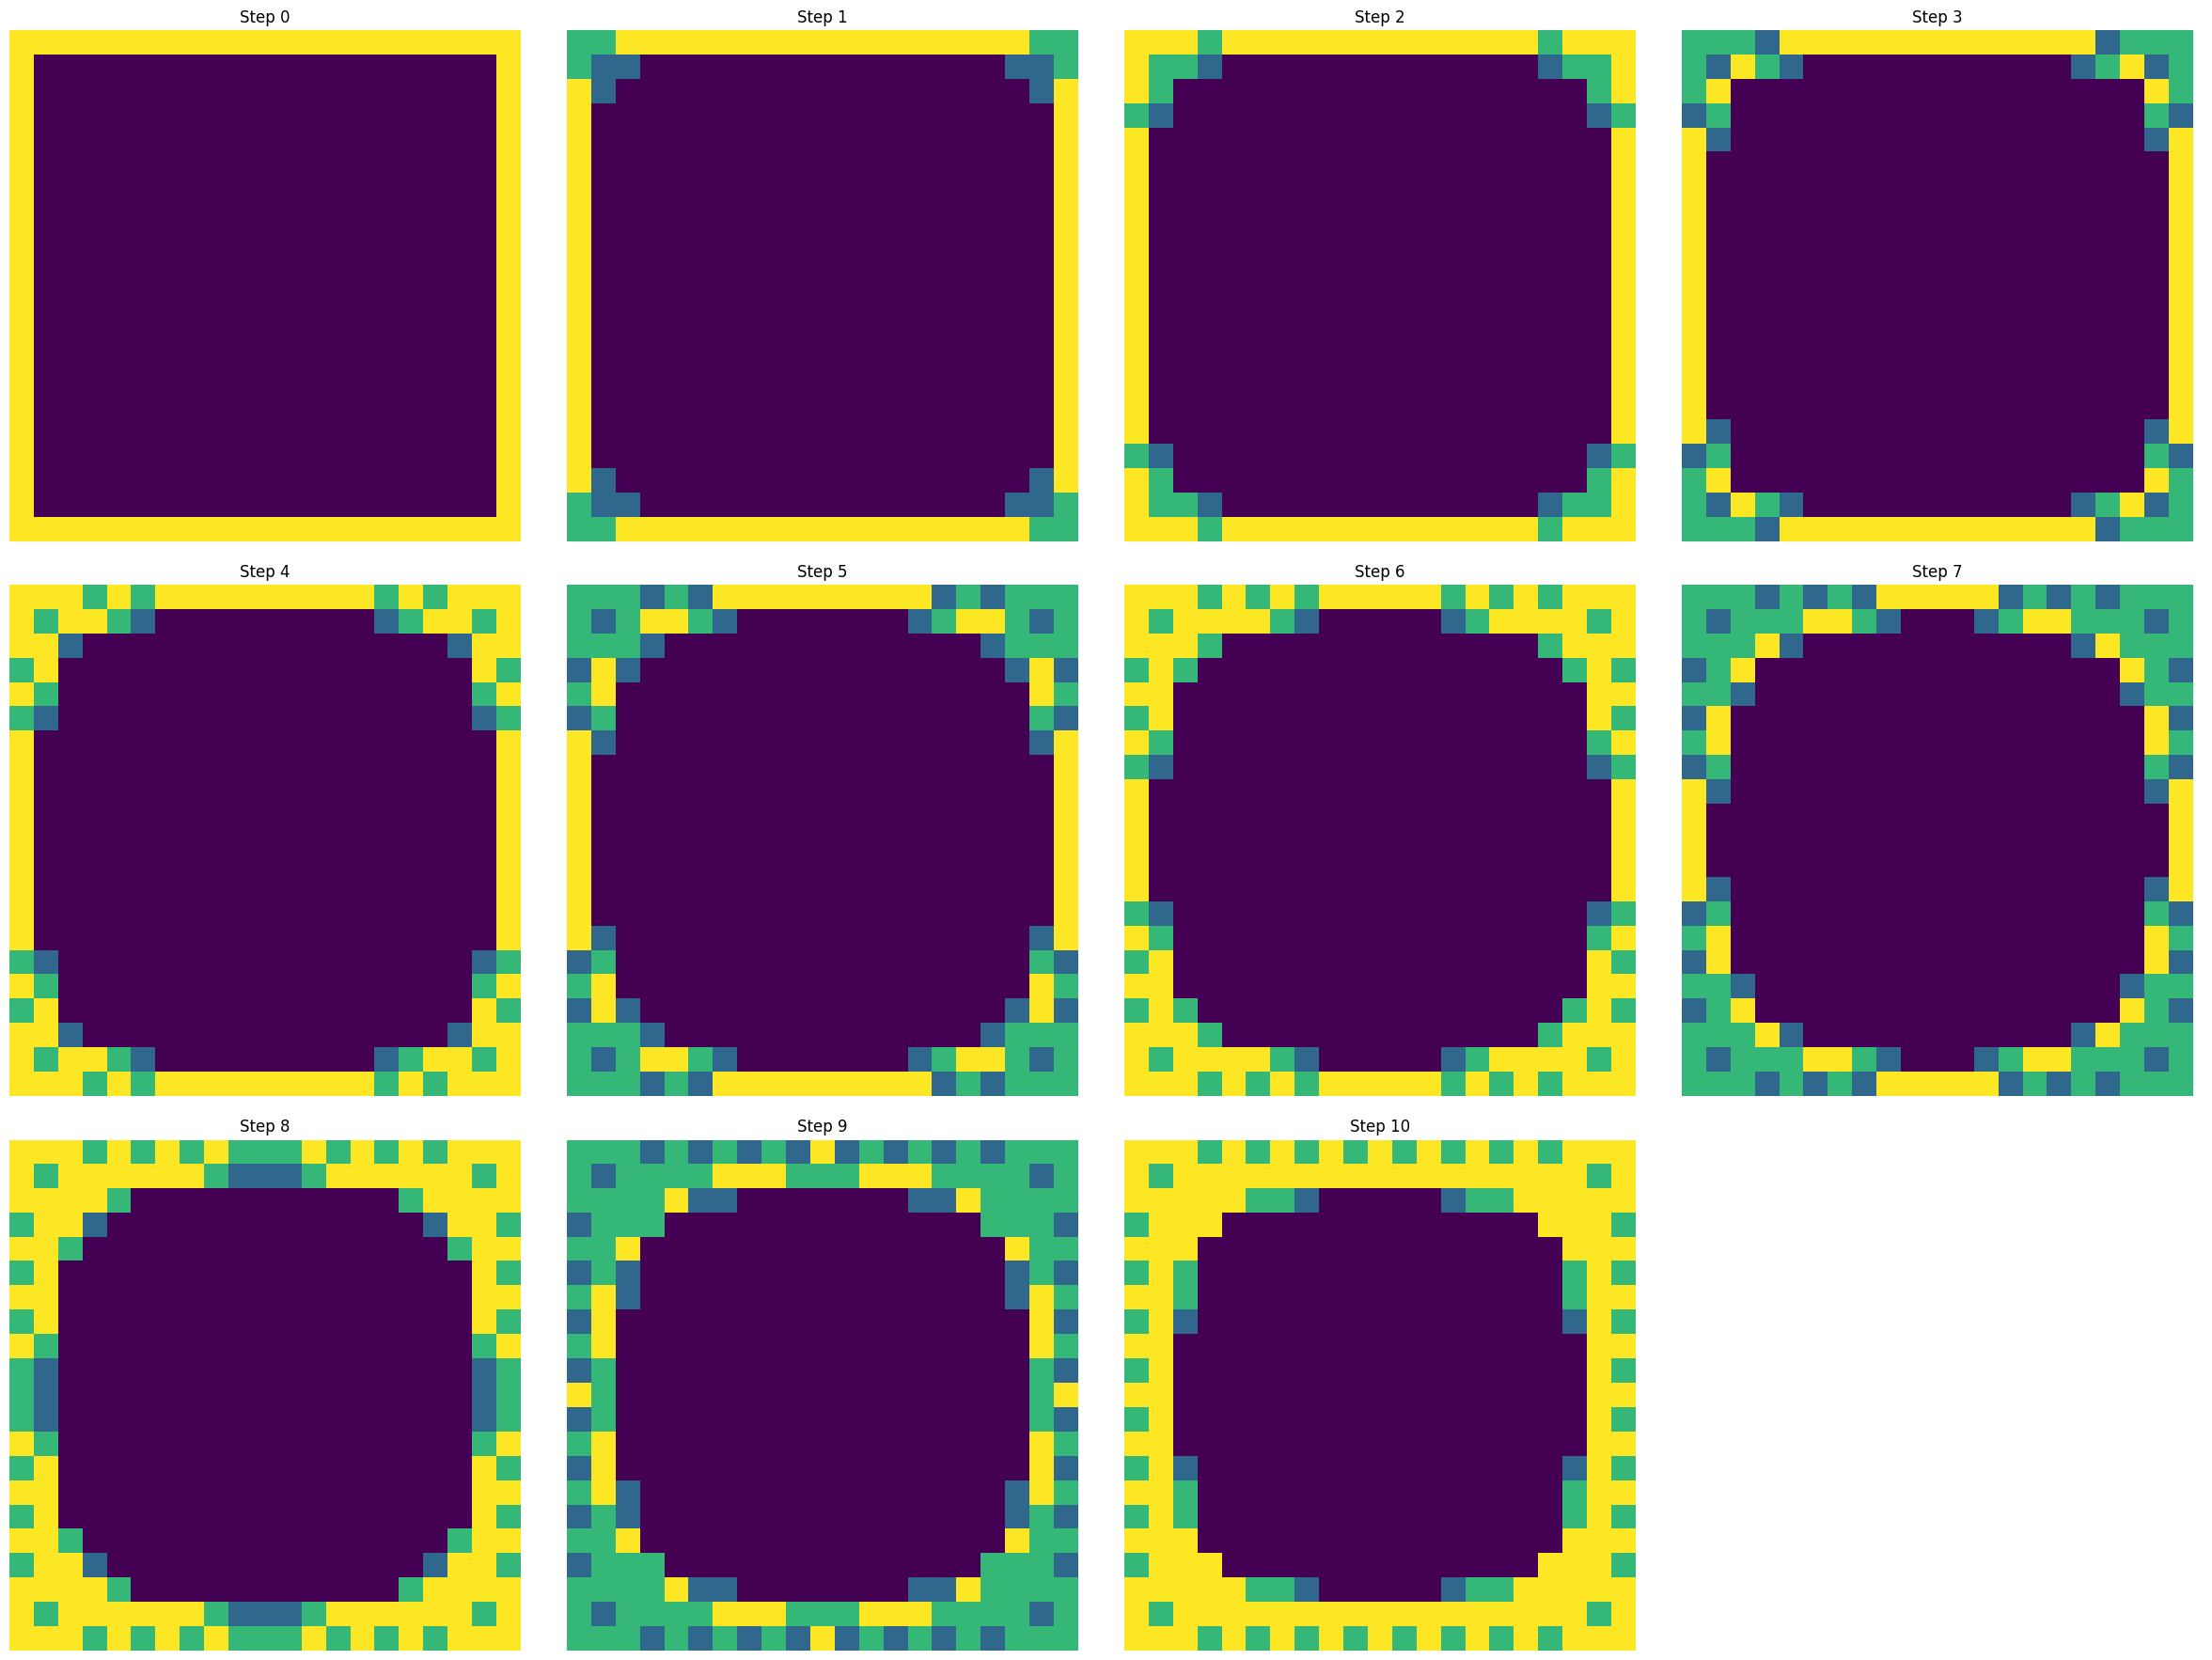

In [325]:
plot_images_wrap(ex2_2)

### 4.3 Ejemplo 3 - Ring en 5D

In [346]:
r = 3
m = 3
d = 5
griz_size = 21
grid = create_grid(d, griz_size, m, pattern='ring')

In [347]:
ex3_1 = visualize_automaton_nd(grid, m=m, r=r, iterations=10, mode='optimized', show=False)

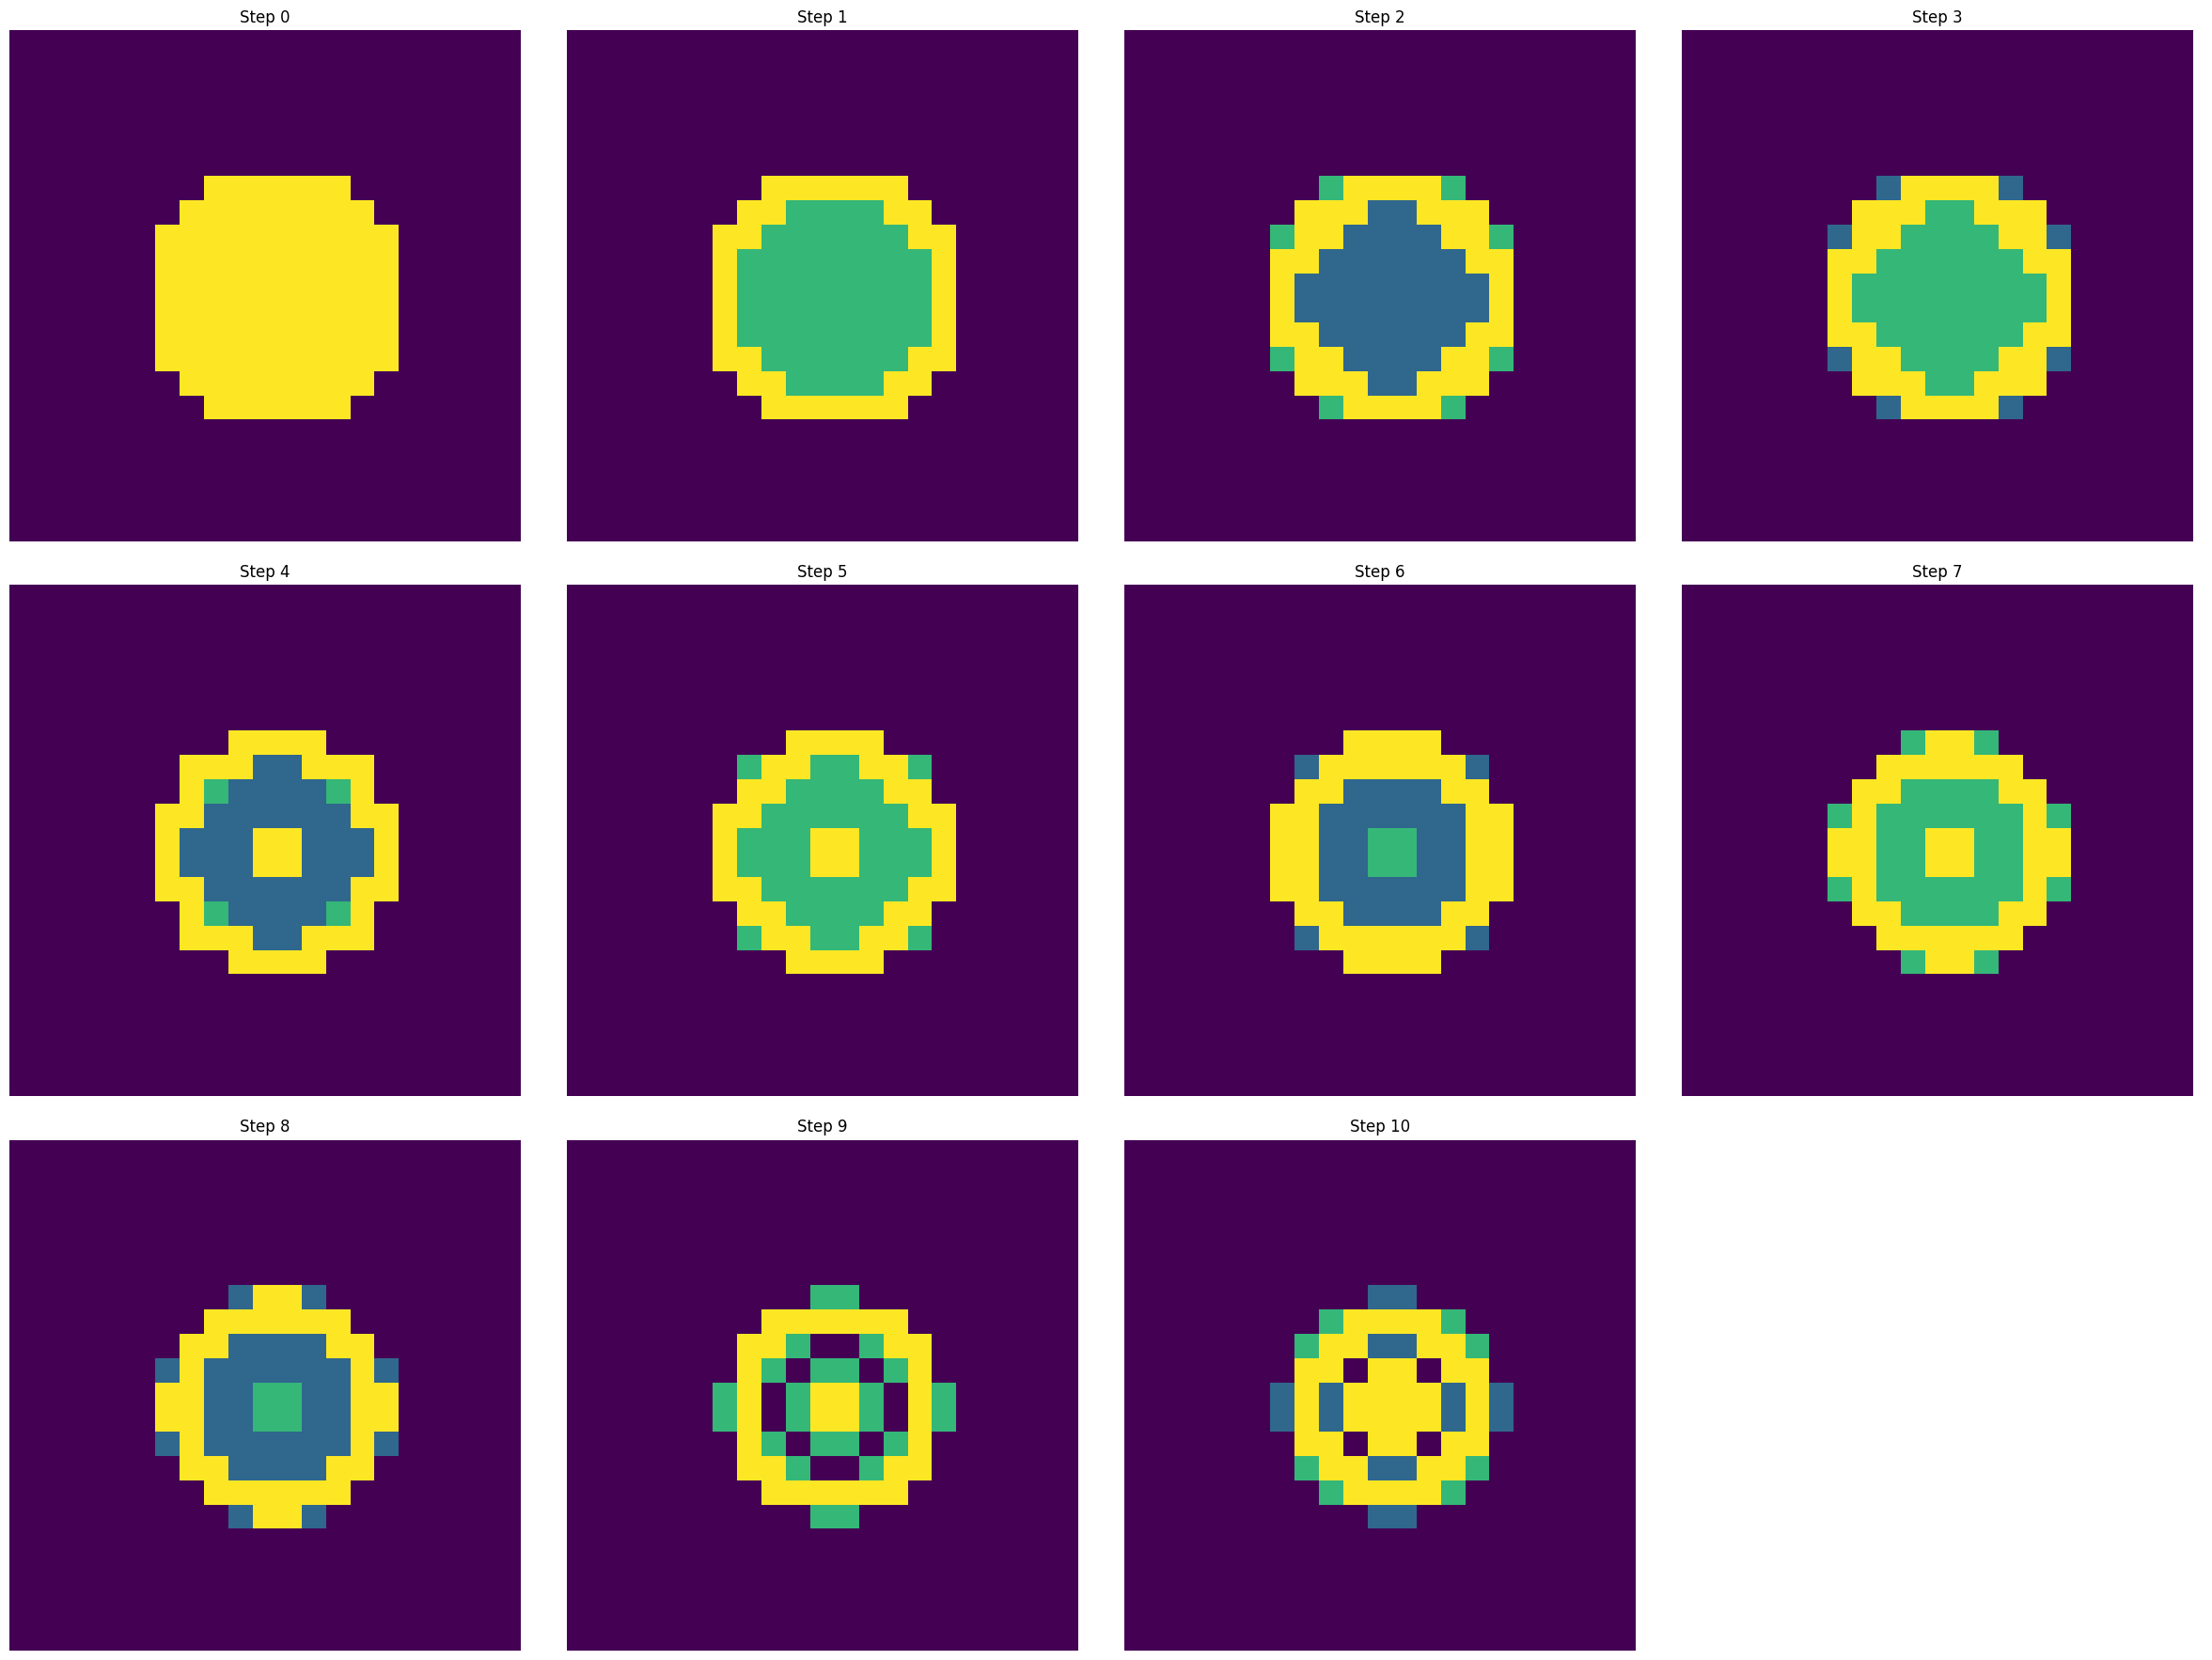

In [406]:
plot_images_wrap(ex3_1, visualization_axes=(0,1))

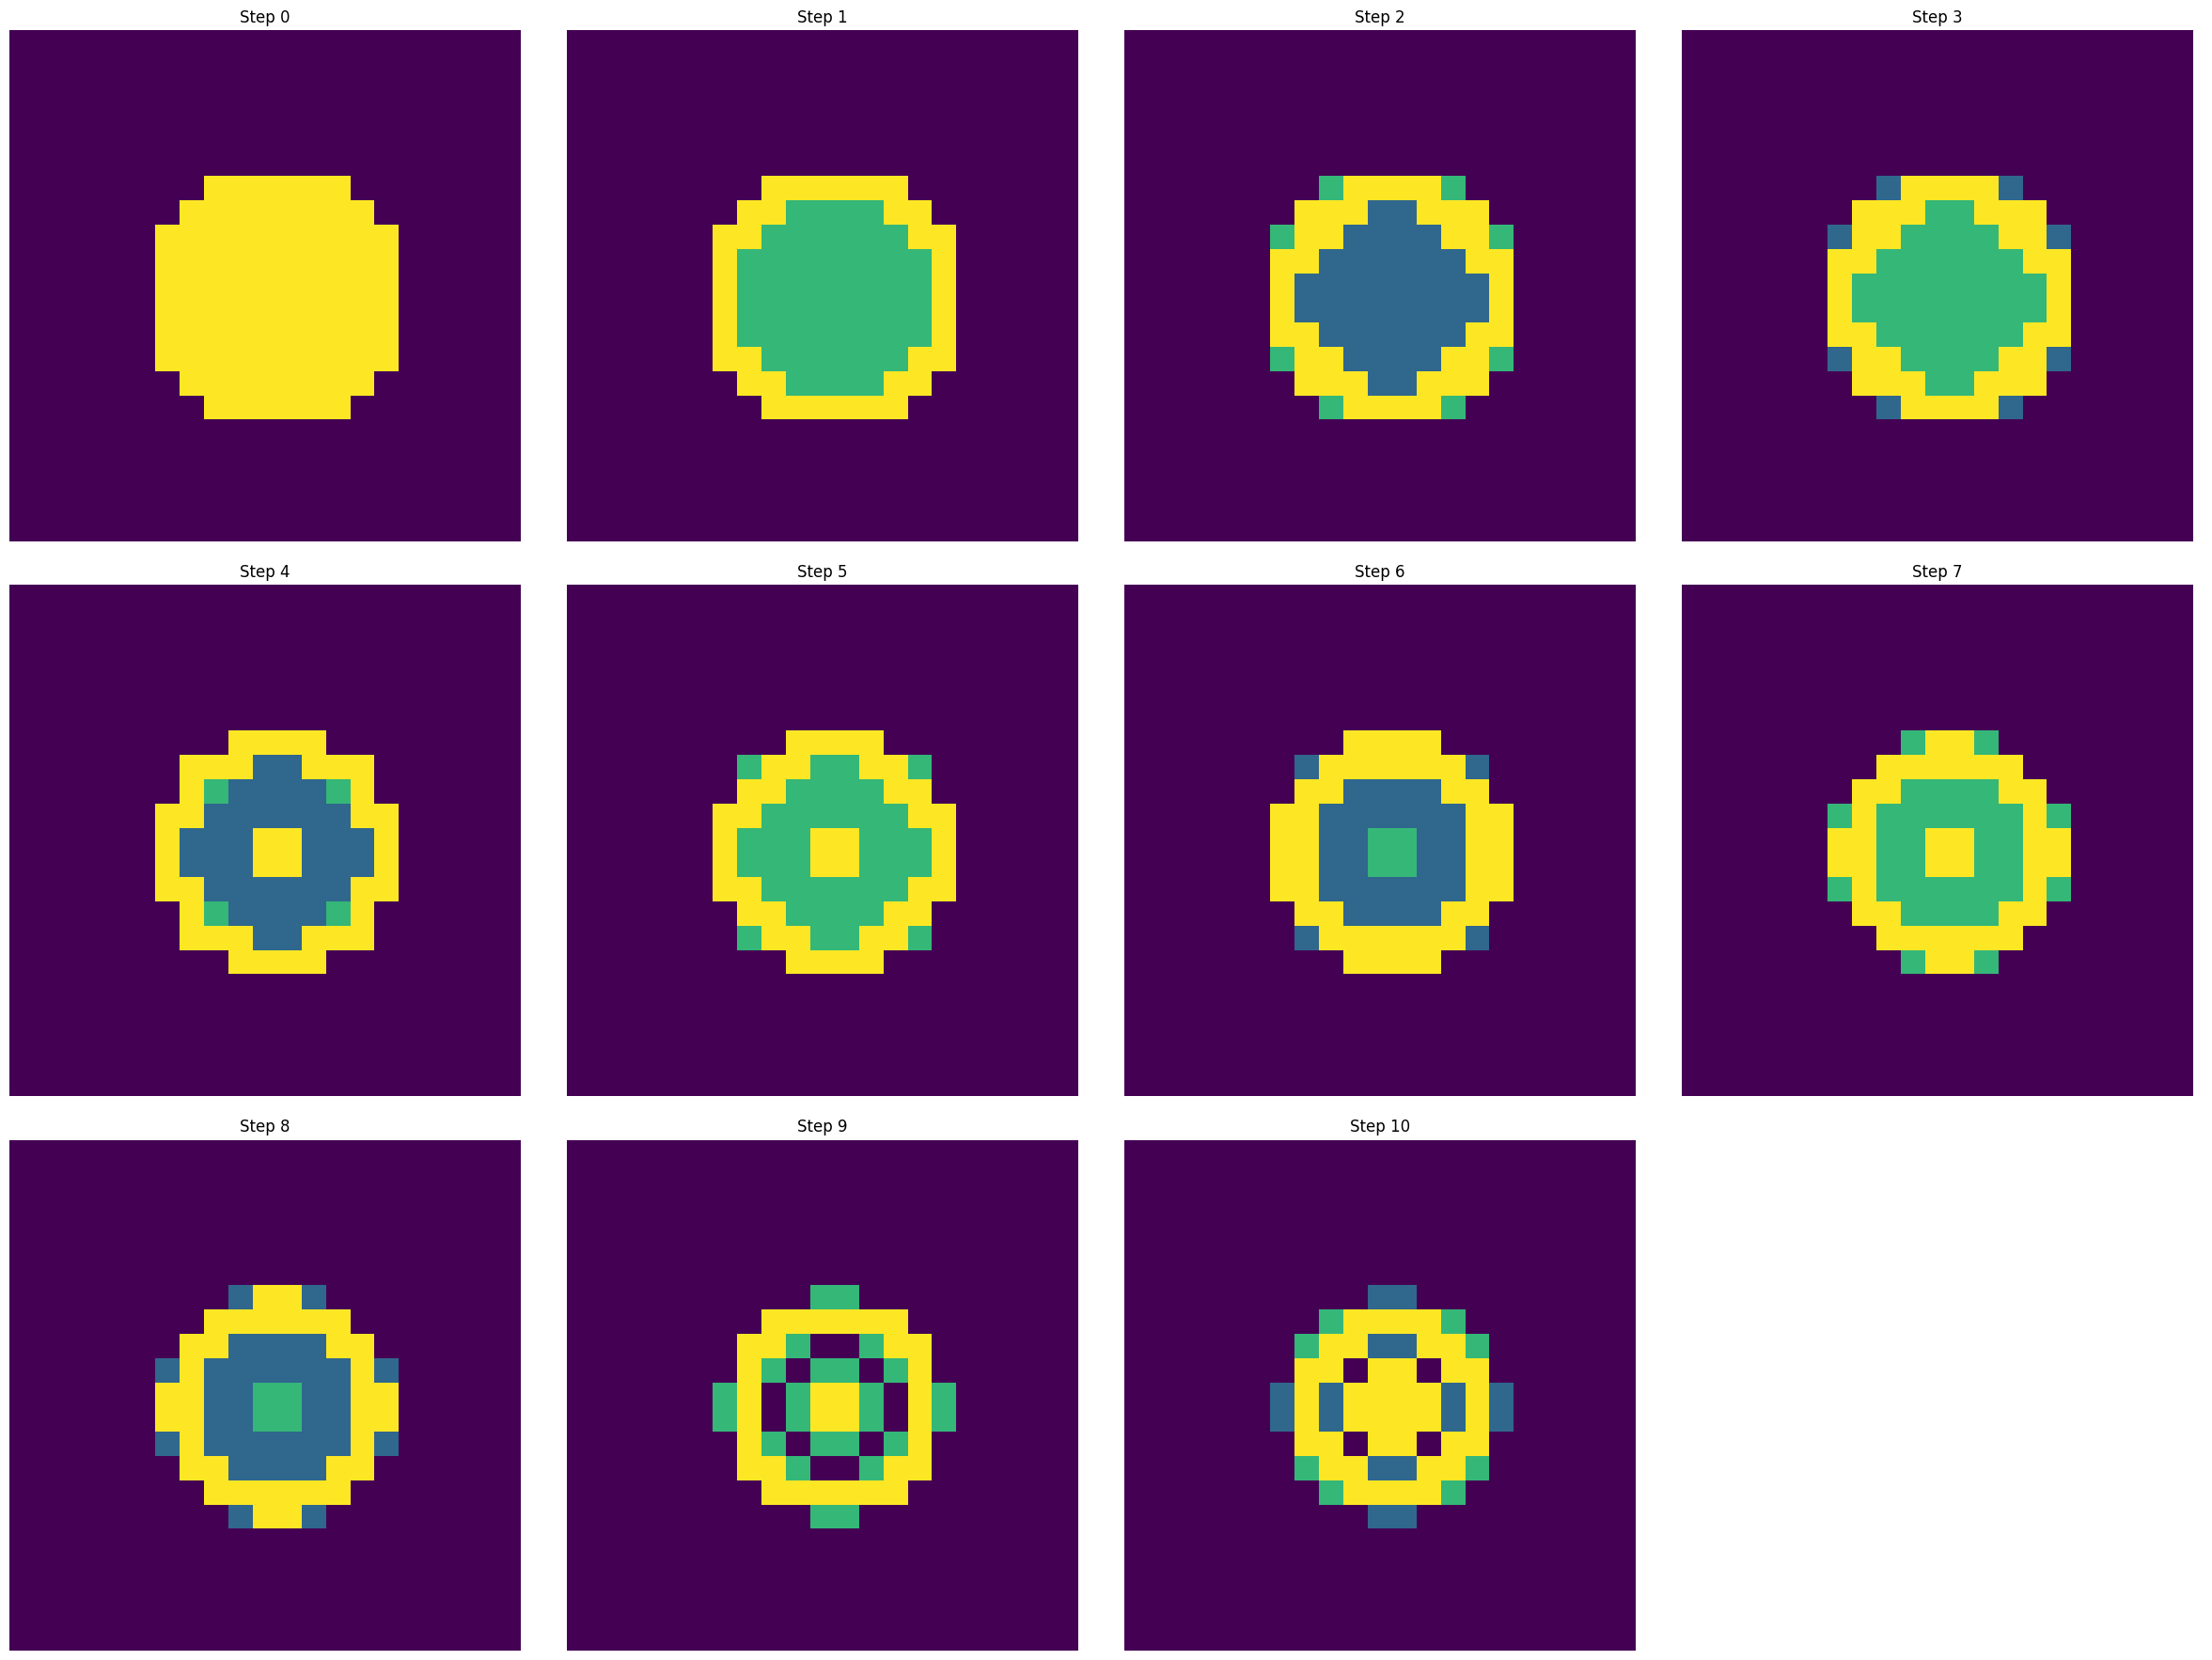

In [349]:
plot_images_wrap(ex3_1, visualization_axes=(1,2))

### 4.4 Ejemplo 4 - Indicador numérico en grilla 3D

In [350]:
import math
import matplotlib.pyplot as plt
import cupy as cp

def plot_images_wrap_test(arrays, cmap='viridis', images_per_row=4, return_sum=False, visualization_axes=(0, 1)):
    """
    Dibuja un listado de arreglos de NumPy apilados horizontalmente y envueltos en múltiples filas.
    
    Parámetros:
    - arrays: listado de arreglos de NumPy a mostrar
    - cmap: mapa de colores para las imágenes (por defecto 'viridis')
    - images_per_row: número de imágenes por fila (por defecto 4)
    - return_sum: Si es True, devuelve una lista con la suma de todos los valores en cada grilla
    - visualization_axes: ejes que se van a visualizar (por defecto, visualiza los ejes 0 y 1)
    
    Retorna:
    - Si return_sum es True, una lista con la suma de los valores de cada grilla. Si no, None.
    """
    
    # Convertir todos los arreglos a cupy.ndarray
    arrays = [cp.asarray(a) for a in arrays]

    # Número de arreglos en la lista
    n = len(arrays)
    
    # Calcular cuántas filas necesitamos (redondeando hacia arriba)
    nrows = math.ceil(n / images_per_row)

    # Crear subgráficos con nrows filas y images_per_row columnas
    fig, axes = plt.subplots(nrows, images_per_row, figsize=(6 * images_per_row, 6 * nrows))

    # Si solo hay una fila o columna, `axes` no será una lista 2D, por lo que la convertimos
    if nrows == 1:
        axes = [axes]
    elif images_per_row == 1:
        axes = [[ax] for ax in axes]

    # Lista donde almacenamos la suma de cada grilla
    sums = []

    # Iterar sobre cada arreglo y su correspondiente subgráfico
    for i, ax_row in enumerate(axes):
        for j, ax in enumerate(ax_row):
            idx = i * images_per_row + j  # Índice de la imagen en la lista de arreglos
            if idx < n:
                # Extraer el arreglo de los ejes especificados
                arr = arrays[idx]
                arr_to_plot = arr[tuple(slice(None) if ax in visualization_axes else slice(arr.shape[ax] // 2, arr.shape[ax] // 2 + 1) for ax in range(len(arr.shape)))] # Selección de ejes para plotear

                # Sumar todos los valores de la grilla si 'return_sum' es True
                if return_sum:
                    sums.append(cp.sum(arr_to_plot).item())

                # Mostrar la imagen
                ax.imshow(arr_to_plot.get(), cmap=cmap, interpolation='nearest')
                ax.set_title(f"Step {idx}")  # Título para cada subgráfico
                ax.axis('off')  # Ocultar los ejes para mejor presentación
            else:
                ax.axis('off')  # Si no hay más imágenes, apagamos el eje

    # Ajustar el layout para que las imágenes no se sobrepongan
    plt.tight_layout(pad=2.0)  # Ajustar el espaciado entre las imágenes

    # Mostrar la imagen en la celda de salida de Jupyter
    plt.show()

    # Retornar la lista de sumas si se solicitó
    if return_sum:
        return sums


In [355]:
r = 2
m = 3
d = 2
griz_size = 7
grid = create_grid(d, griz_size, m, pattern='cross')

In [358]:
a = visualize_automaton(grid, m, r, iterations=20, show=False)

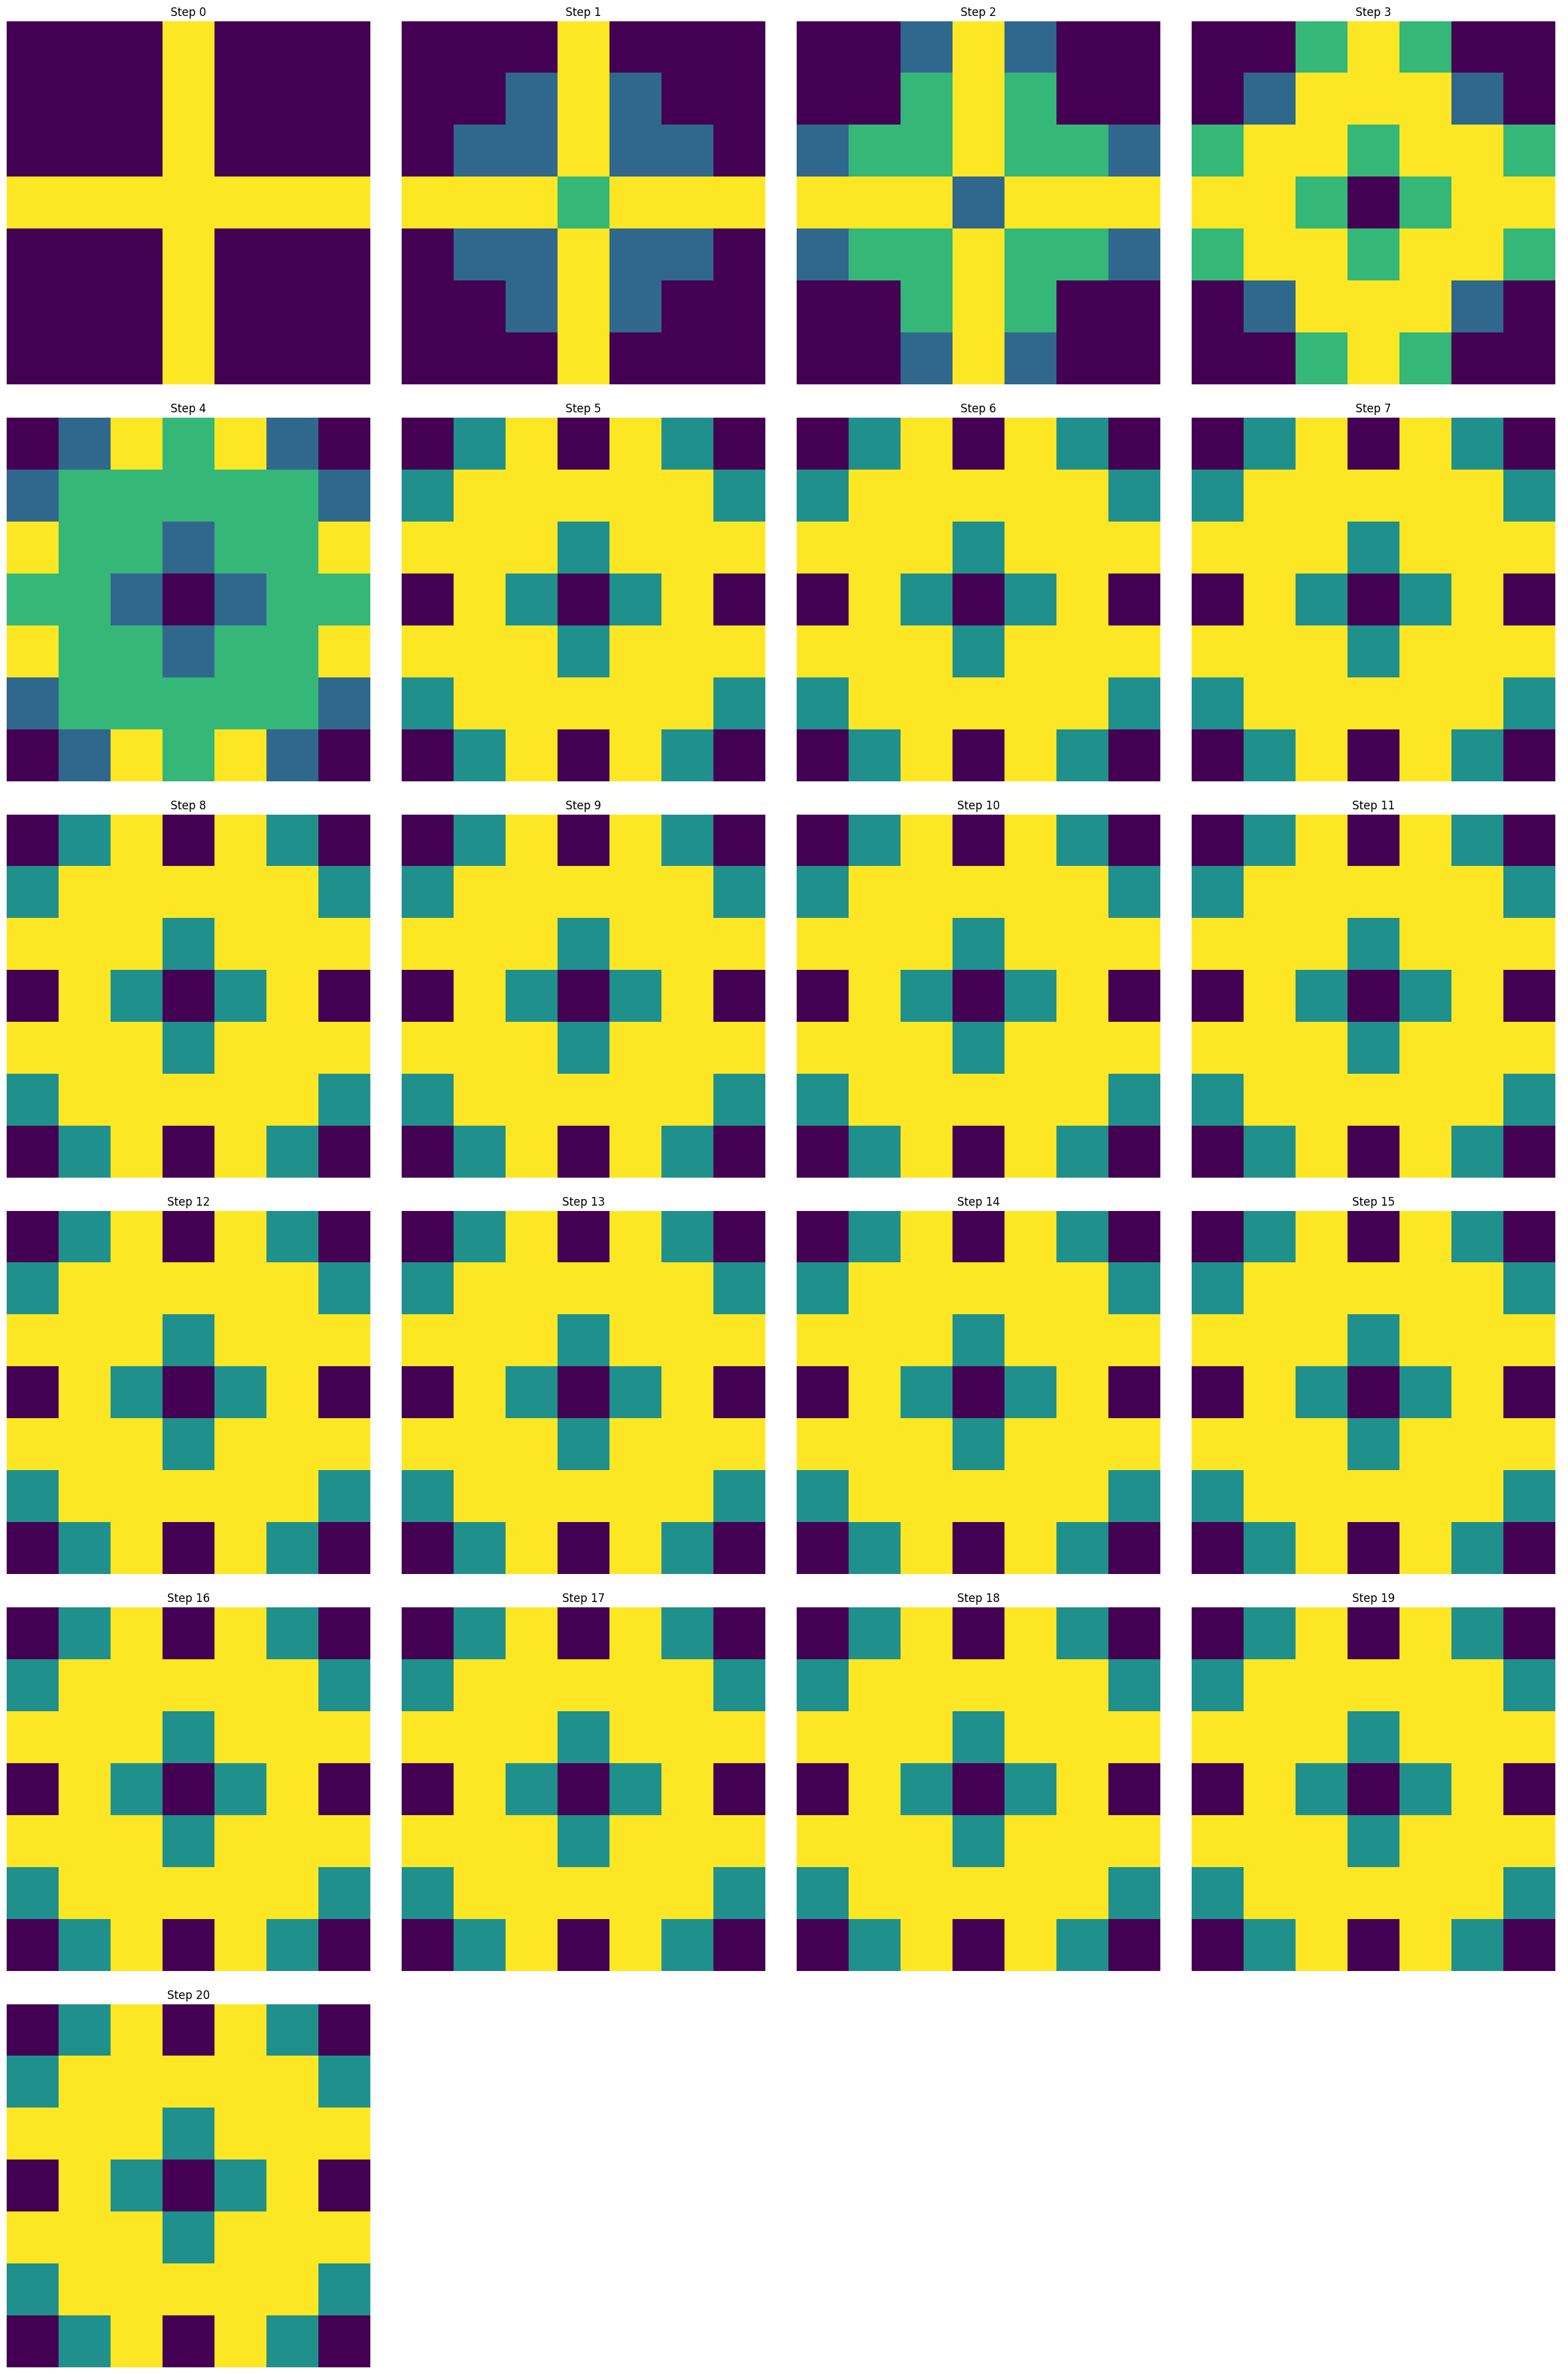

[39,
 50,
 69,
 88,
 84,
 117,
 68,
 117,
 68,
 117,
 68,
 117,
 68,
 117,
 68,
 117,
 68,
 117,
 68,
 117,
 68]

In [359]:
plot_images_wrap_test(a, return_sum=True)